## Daily Data

SF and MX decompositions for one year of data (output101, 1 degree model) 

#### Issues: 
- Running on analysis3-22.01, where xhistogram has a funny naming convention when temperature needs to be interpolated. But on analysis-22.04 there is some issue with xgcm.
# - missing important 1 degree diagnostics!!

In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/42655/status,
Dashboard: /proxy/42655/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38289,Workers: 8
Dashboard: /proxy/42655/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:45399,Total threads: 1
Dashboard: /proxy/38851/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41889,


In [3]:
# files:
base = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/';
xch = 360#2*288
ych = 240#2*216

fgrd   = xr.open_dataset(base + 'output101/ocean/ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_wmass_mean.nc').chunk({'grid_yt_ocean':ych/10,'grid_yu_ocean':ych/10,'grid_xt_ocean':xch/10})
fmonth_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_month_mean.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10})
fheat_mean = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/ocean_heat_mean.nc').chunk({'yt_ocean':ych/10,'xt_ocean':xch/10})

# load RYF monthly data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fmonth_m = xr.open_mfdataset(base_msc+'ocean/ocean_month.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_m = xr.open_mfdataset(base_msc+'ocean/ocean_heat.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_m = xr.open_mfdataset(base_msc+'ocean/ocean_wmass.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# load RYF daily data
base_msc = '/scratch/e14/cy8964/access-om2/archive/1deg_jra55_ryf/output101/'
# ---------------------------------------------------------------------------------- #
# load in data set ----------------------------------------------------------------- #
fdaily = xr.open_mfdataset(base_msc+'ocean/ocean_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fheat_daily = xr.open_mfdataset(base_msc+'ocean/ocean_heat_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'yt_ocean':ych/10,'xt_ocean':xch/10})
fwmass_daily = xr.open_mfdataset(base_msc+'ocean/ocean_wmass_daily.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
gridmn = Grid(fmonth_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridht = Grid(fheat_m,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)
gridd = Grid(fdaily,coords={"x":{"center":"xt_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"},
                             "z":{"center":"st_ocean","outer":"st_edges_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})

Define some functions

In [4]:
def running_av_2mos(variable):
    month_length = variable.time.dt.days_in_month
    running_mean = (variable*month_length).roll(time = 1, roll_coords = False)+ (variable*month_length)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    running_mean = running_mean/time_length
    return running_mean


In [5]:
def running_av_10days(variable):
    running_mean = (variable).roll(time = 1, roll_coords = False)+ (variable) + (variable).roll(time = 2, roll_coords = False)+ (variable).roll(time = 3, roll_coords = False)+(variable).roll(time = 4, roll_coords = False)+(variable).roll(time = 5, roll_coords = False)+(variable).roll(time = 6, roll_coords = False)+(variable).roll(time = 7, roll_coords = False)+(variable).roll(time = 8, roll_coords = False)+(variable).roll(time = 9, roll_coords = False)#.roll(time = -1, roll_coords = False)+2*(variable*month_length)
    running_mean = running_mean/10
    return running_mean


In [6]:
def running_av_2mos_mo(variable):
    month_length = variable.time.dt.days_in_month
    time_length = (month_length).roll(time = 1, roll_coords = False)+ (month_length)#.roll(time = -1, roll_coords = False)+2*(month_length)
    time_length = time_length/2
    return time_length

In [7]:
def weighted_time_mean_2mo_filter(variable):
    month_length = running_av_2mos_mo(variable.time.dt.days_in_month)
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [8]:
def weighted_time_mean(variable):
    month_length = variable.time.dt.days_in_month
    time_mean = (variable*month_length).sum('time')/(month_length.sum('time'))
    return time_mean

In [9]:
def weighted_time_mean_2mo_filter_mo(variable, variable1):
    month_length = running_av_2mos(variable1.time.dt.days_in_month).groupby('time.month').mean('time')
    time_mean = (variable*month_length).sum('month')/(month_length.sum('month'))
    return time_mean

In [10]:
fheat_m.average_DT.values/3600/24/1e9

array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31],
      dtype='timedelta64[ns]')

#### COMPUTATION OF TIME MEANS

Here I calculate time means using my weighted time mean function, and save them out.

In [10]:
%%time
## correct time means of ocean_wmass.nc

# weighted time average
mean_ty_trans_nrho = weighted_time_mean(fwmass_m.ty_trans_nrho)
mean_temp_vdiffuse_sbc_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_sbc_on_nrho)
mean_sfc_hflux_pme_on_nrho = weighted_time_mean(fwmass_m.sfc_hflux_pme_on_nrho)
mean_frazil_on_nrho = weighted_time_mean(fwmass_m.frazil_on_nrho)
mean_sw_heat_on_nrho = weighted_time_mean(fwmass_m.sw_heat_on_nrho)
mean_temp_vdiffuse_diff_cbt_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_on_nrho)
mean_temp_nonlocal_KPP_on_nrho = weighted_time_mean(fwmass_m.temp_nonlocal_KPP_on_nrho)

mean_sw_heat_on_nrho = weighted_time_mean(fwmass_m.sw_heat_on_nrho)
mean_temp_vdiffuse_diff_cbt_kppish_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppish_on_nrho)
mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppicon_on_nrho)
mean_vdiffuse_diff_cbt_kppbl_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppbl_on_nrho)
mean_temp_vdiffuse_diff_cbt_wave_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_wave_on_nrho)
mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho = weighted_time_mean(fwmass_m.temp_vdiffuse_diff_cbt_kppdd_on_nrho)

# load
mean_ty_trans_nrho.load()
mean_temp_vdiffuse_sbc_on_nrho.load()
mean_sfc_hflux_pme_on_nrho.load()
mean_frazil_on_nrho.load()
mean_sw_heat_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_on_nrho.load()
mean_temp_nonlocal_KPP_on_nrho.load()
mean_sw_heat_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppish_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho.load()
mean_vdiffuse_diff_cbt_kppbl_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_wave_on_nrho.load()
mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho.load()

CPU times: user 7.91 s, sys: 1.58 s, total: 9.5 s
Wall time: 22.5 s


<xarray.DataArray (neutral: 74, grid_yt_ocean: 300, grid_xt_ocean: 360)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_xt_ocean  (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutral        (neutral) float64 -2.75 -2.25 -1.75 ... 32.75 33.25 33.75
  * grid_yt_ocean  (grid_yt_ocean) float64 -77.88 -77.63 -77.38 ... 89.32 89.77

In [11]:
# save to ncfile
ds = xr.Dataset({'ty_trans_nrho': mean_ty_trans_nrho, 'temp_vdiffuse_sbc_on_nrho': mean_temp_vdiffuse_sbc_on_nrho, 
                 'sfc_hflux_pme_on_nrho':mean_sfc_hflux_pme_on_nrho, 'frazil_on_nrho':mean_frazil_on_nrho,
                 'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_on_nrho':mean_temp_vdiffuse_diff_cbt_on_nrho,
                 'temp_nonlocal_KPP_on_nrho':mean_temp_nonlocal_KPP_on_nrho,'temp_vdiffuse_diff_cbt_kppdd_on_nrho':mean_temp_vdiffuse_diff_cbt_kppdd_on_nrho,
                 'sw_heat_on_nrho':mean_sw_heat_on_nrho,'temp_vdiffuse_diff_cbt_kppish_on_nrho':mean_temp_vdiffuse_diff_cbt_kppish_on_nrho,
                 'temp_vdiffuse_diff_cbt_kppicon_on_nrho':mean_temp_vdiffuse_diff_cbt_kppicon_on_nrho,'temp_vdiffuse_diff_cbt_kppbl_on_nrho':mean_vdiffuse_diff_cbt_kppbl_on_nrho,
                 'temp_vdiffuse_diff_cbt_wave_on_nrho':mean_temp_vdiffuse_diff_cbt_wave_on_nrho})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/ocean_wmass_mean.nc', 
         encoding={'ty_trans_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave_on_nrho': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [11]:
%%time
## correct time means of ocean_heat.nc

# weighted time average
mean_temp_vdiffuse_sbc = weighted_time_mean(fheat_m.temp_vdiffuse_sbc)
mean_sfc_hflux_pme = weighted_time_mean(fheat_m.sfc_hflux_pme)
mean_frazil_3d = weighted_time_mean(fheat_m.frazil_3d)
mean_sw_heat = weighted_time_mean(fheat_m.sw_heat)
mean_temp_vdiffuse_diff_cbt = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt)
mean_temp_nonlocal_KPP = weighted_time_mean(fheat_m.temp_nonlocal_KPP)

mean_sw_heat = weighted_time_mean(fheat_m.sw_heat)
mean_temp_vdiffuse_diff_cbt_kppish = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppish)
mean_temp_vdiffuse_diff_cbt_kppicon = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppicon)
mean_vdiffuse_diff_cbt_kppbl = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppbl)
mean_temp_vdiffuse_diff_cbt_wave = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_wave)
mean_temp_vdiffuse_diff_cbt_kppdd = weighted_time_mean(fheat_m.temp_vdiffuse_diff_cbt_kppdd)

# load
mean_temp_vdiffuse_sbc.load()
mean_sfc_hflux_pme.load()
mean_frazil_3d.load()
mean_sw_heat.load()
mean_temp_vdiffuse_diff_cbt.load()
mean_temp_nonlocal_KPP.load()
mean_temp_vdiffuse_diff_cbt_kppish.load()
mean_temp_vdiffuse_diff_cbt_kppicon.load()
mean_vdiffuse_diff_cbt_kppbl.load()
mean_temp_vdiffuse_diff_cbt_wave.load()
mean_temp_vdiffuse_diff_cbt_kppdd.load()

# save to ncfile
ds = xr.Dataset({'temp_vdiffuse_sbc': mean_temp_vdiffuse_sbc, 
                 'sfc_hflux_pme':mean_sfc_hflux_pme, 'frazil_3d':mean_frazil_3d,
                 'sw_heat':mean_sw_heat,'temp_vdiffuse_diff_cbt':mean_temp_vdiffuse_diff_cbt,
                 'temp_nonlocal_KPP':mean_temp_nonlocal_KPP,'temp_vdiffuse_diff_cbt_kppdd':mean_temp_vdiffuse_diff_cbt_kppdd,
                 'temp_vdiffuse_diff_cbt_kppish':mean_temp_vdiffuse_diff_cbt_kppish,
                 'temp_vdiffuse_diff_cbt_kppicon':mean_temp_vdiffuse_diff_cbt_kppicon,'temp_vdiffuse_diff_cbt_kppbl':mean_vdiffuse_diff_cbt_kppbl,
                 'temp_vdiffuse_diff_cbt_wave':mean_temp_vdiffuse_diff_cbt_wave})
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/ocean_heat_mean.nc', 
         encoding={'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})



CPU times: user 33.3 s, sys: 4.02 s, total: 37.3 s
Wall time: 52.9 s


In [14]:
%%time
## correct time means of ocean_month.nc

# weighted time average
mean_temp = weighted_time_mean(fmonth_m.temp)
mean_ty_trans = weighted_time_mean(fmonth_m.ty_trans)

# load
mean_temp.load()
mean_ty_trans.load()

# save to ncfile
ds = xr.Dataset({'temp': mean_temp, 'ty_trans':mean_ty_trans, })
                 
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/ocean_month_mean.nc', 
         encoding={'temp': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'ty_trans': {'shuffle': True, 'zlib': True, 'complevel': 5}})



CPU times: user 2.53 s, sys: 312 ms, total: 2.85 s
Wall time: 3.82 s


### Continue Here:

In [17]:
# Group SF and MX terms for monthly data:
fwmass_m["SF_cv"] = fwmass_m.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_m.sfc_hflux_pme_on_nrho + \
                       fwmass_m.frazil_on_nrho + \
                       fwmass_m.sw_heat_on_nrho# + \
#                       fwmass_m.temp_rivermix_on_nrho
fwmass_m["MX_cv"] = fwmass_m.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_m.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_m.sfc_hflux_pme,fheat_m.temp_vdiffuse_sbc)
sfc_hflux_pme_m = obj.where(fheat_m.st_ocean==fheat_m.st_ocean[0],other=0.)

fheat_m["SF_cv"] = fheat_m.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_m + \
                      fheat_m.frazil_3d + \
                      fheat_m.sw_heat# + \
#                      fheat_m.temp_rivermix
fheat_m["MX_cv"] = fheat_m.temp_vdiffuse_diff_cbt + \
                      fheat_m.temp_nonlocal_KPP 
# Group SF and MX terms for daily data:

obj, obj2 = xr.broadcast(fheat_daily.sfc_hflux_pme,fheat_daily.temp_vdiffuse_sbc)
sfc_hflux_pme_daily = obj.where(fheat_daily.st_ocean==fheat_daily.st_ocean[0],other=0.)

fheat_daily["MX_cv"] = fheat_daily.temp_vdiffuse_diff_cbt + \
                      fheat_daily.temp_nonlocal_KPP 
fheat_daily["SF_cv"] = fheat_daily.temp_vdiffuse_sbc + \
                      fheat_daily.sw_heat + \
                      fheat_daily.frazil_3d + \
                      sfc_hflux_pme_daily 
#                      fheat_sc.temp_rivermix
fwmass_daily["MX_cv"] = fwmass_daily.temp_vdiffuse_diff_cbt_on_nrho + \
                      fwmass_daily.temp_nonlocal_KPP_on_nrho 
fwmass_daily["SF_cv"] = fwmass_daily.temp_vdiffuse_sbc_on_nrho + \
                      fwmass_daily.sw_heat_on_nrho + \
                      fwmass_daily.sfc_hflux_pme_on_nrho + \
                      fwmass_daily.frazil_on_nrho
# Group mean SF and MX terms:
fwmass_mean["SF_cv"] = fwmass_mean.temp_vdiffuse_sbc_on_nrho + \
                       fwmass_mean.sfc_hflux_pme_on_nrho + \
                       fwmass_mean.frazil_on_nrho + \
                       fwmass_mean.sw_heat_on_nrho #+ \
                       #fwmass_mean.temp_rivermix_on_nrho
fwmass_mean["MX_cv"] = fwmass_mean.temp_vdiffuse_diff_cbt_on_nrho + \
                       fwmass_mean.temp_nonlocal_KPP_on_nrho 

obj, obj2 = xr.broadcast(fheat_mean.sfc_hflux_pme,fheat_mean.temp_vdiffuse_sbc)
sfc_hflux_pme_mean = obj.where(fheat_mean.st_ocean==fheat_mean.st_ocean[0],other=0.)

fheat_mean["SF_cv"] = fheat_mean.temp_vdiffuse_sbc + \
                      sfc_hflux_pme_mean + \
                      fheat_mean.frazil_3d + \
                      fheat_mean.sw_heat # + \
#                      fheat_mean.temp_rivermix
fheat_mean["MX_cv"] = fheat_mean.temp_vdiffuse_diff_cbt + \
                      fheat_mean.temp_nonlocal_KPP


Calculate running 2 month means and save them in same DataSets for ease of use with xgcm.
Binning done with xhistogram to capture partial cells.

In [18]:
tbins = fwmass_m.neutralrho_edges.values

In [19]:
# calculate a running mean of 2 months of ty_trans_nrho, temp and ty_trans and add them back into datasets
fwmass_m['ty_trans_nrho_2mo'] = running_av_2mos(fwmass_m.ty_trans_nrho)
fmonth_m['temp_2mo'] = running_av_2mos(fmonth_m.temp)
fmonth_m['ty_trans_2mo'] = running_av_2mos(fmonth_m.ty_trans)

#fwmass_daily['ty_trans_nrho_10day']= running_av_10days(fwmass_daily.ty_trans_nrho)
fdaily['temp_10day'] = running_av_10days(fdaily.temp)
fdaily['ty_trans_10day'] = running_av_10days(fdaily.ty_trans)

# temperature binning of time-mean (2 month running average of both temp and ty_trans):
temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
fwmass_m["ty_trans_nrho_mean_2mo"] = histogram(temp_u_mean, bins=[tbins], dim = ['st_ocean'],weights=fmonth_m.ty_trans_2mo).rename({temp_u_mean.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
# temperature binning of 10daily
temp_u_10daily = gridd.interp(fdaily.temp_10day,'y',boundary='extend')-273.15
fwmass_daily["ty_trans_nrho_mean_10day"] = histogram(temp_u_10daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans_10day).rename({temp_u_10daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# temperature binning of 1daily
temp_u_daily = gridd.interp(fdaily.temp,'y',boundary='extend')-273.15
fwmass_daily["ty_trans_nrho_mean_1day"] = histogram(temp_u_daily, bins=[tbins], dim = ['st_ocean'],weights=fdaily.ty_trans).rename({temp_u_daily.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})

# temperature binning of 1 year
temp_u_mean_tot = gridmn.interp(fmonth_mean.temp,'y',boundary='extend')-273.15
fwmass_mean["ty_trans_nrho_mean_1yr"] = histogram(temp_u_mean_tot, bins=[tbins], dim = ['st_ocean'],weights=fmonth_mean.ty_trans).rename({temp_u_mean_tot.name+'_bin':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})


now do running averages of surface flux and mixing:

In [20]:
# calculate a running mean of 2 months of things
fheat_m['SF_cv_2mo'] = running_av_2mos(fheat_m.SF_cv)
fheat_m['MX_cv_2mo'] = running_av_2mos(fheat_m.MX_cv)

fheat_m['sw_heat_2mo'] = running_av_2mos(fheat_m.sw_heat)
fheat_m['frazil_3d_2mo'] = running_av_2mos(fheat_m.frazil_3d)
fheat_m['temp_vdiffuse_sbc_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_sbc)
fheat_m['sfc_hflux_pme_2mo'] = running_av_2mos(fheat_m.sfc_hflux_pme)
fheat_m['temp_nonlocal_KPP_2mo'] = running_av_2mos(fheat_m.temp_nonlocal_KPP)
fheat_m['temp_vdiffuse_diff_cbt_kppish_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppish)
fheat_m['temp_vdiffuse_diff_cbt_kppicon_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppicon)
fheat_m['temp_vdiffuse_diff_cbt_kppbl_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppbl)
fheat_m['temp_vdiffuse_diff_cbt_kppdd_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_kppdd)
fheat_m['temp_vdiffuse_diff_cbt_wave_2mo'] = running_av_2mos(fheat_m.temp_vdiffuse_diff_cbt_wave)

##10 day means

fheat_daily['SF_cv_10day'] = running_av_10days(fheat_daily.SF_cv)
fheat_daily['MX_cv_10day'] = running_av_10days(fheat_daily.MX_cv)

fheat_daily['sw_heat_10day'] = running_av_10days(fheat_daily.sw_heat)
fheat_daily['frazil_3d_10day'] = running_av_10days(fheat_daily.frazil_3d)
fheat_daily['temp_vdiffuse_sbc_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_sbc)
fheat_daily['sfc_hflux_pme_10day'] = running_av_10days(fheat_daily.sfc_hflux_pme)
fheat_daily['temp_nonlocal_KPP_10day'] = running_av_10days(fheat_daily.temp_nonlocal_KPP)
fheat_daily['temp_vdiffuse_diff_cbt_kppish_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppish)
fheat_daily['temp_vdiffuse_diff_cbt_kppicon_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppicon)
fheat_daily['temp_vdiffuse_diff_cbt_kppbl_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppbl)
fheat_daily['temp_vdiffuse_diff_cbt_kppdd_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_kppdd)
fheat_daily['temp_vdiffuse_diff_cbt_wave_10day'] = running_av_10days(fheat_daily.temp_vdiffuse_diff_cbt_wave)



Bin daily and 10daily

In [21]:
# temperature binning of daily and 10 daily data
# SF and MX:
fwmass_daily["SF_cv_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["MX_cv_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["SF_cv_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.SF_cv_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["MX_cv_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.MX_cv_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

# SF decomposition
fwmass_daily["sw_heat_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["sw_heat_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sw_heat_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["frazil_3d_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["frazil_3d_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.frazil_3d_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_sbc_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_sbc_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_sbc_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["sfc_hflux_pme_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sfc_hflux_pme).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["sfc_hflux_pme_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.sfc_hflux_pme_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

# MX decomposition

fwmass_daily["temp_nonlocal_KPP_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_nonlocal_KPP).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_nonlocal_KPP_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_nonlocal_KPP_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


fwmass_daily["temp_vdiffuse_diff_cbt_kppish_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppish_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppish_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppicon_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppicon_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppbl_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppbl_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppbl_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_kppdd_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_kppdd_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_1day"] = histogram(fdaily.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_daily["temp_vdiffuse_diff_cbt_wave_mean_10day"] = histogram(fdaily.temp_10day-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_daily.temp_vdiffuse_diff_cbt_wave_10day).rename({'temp_10day_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


Bin two month binned things into temperature space

In [22]:
# temperature binning of 2 month mean
# SF and MX:
#temp_u_mean = gridmn.interp(fmonth_m.temp_2mo,'y',boundary='extend')-273.15
fwmass_m["SF_cv_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.SF_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["MX_cv_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.MX_cv_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["sw_heat_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.sw_heat_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["frazil_3d_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.frazil_3d_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_sbc_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_sbc_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["sfc_hflux_pme_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.sfc_hflux_pme_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_nonlocal_KPP_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_nonlocal_KPP_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

fwmass_m["temp_vdiffuse_diff_cbt_kppish_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppish_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppicon_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppicon_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppbl_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppbl_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_kppdd_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_kppdd_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_m["temp_vdiffuse_diff_cbt_wave_mean_2mo"] = histogram(fmonth_m.temp_2mo-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_m.temp_vdiffuse_diff_cbt_wave_2mo).rename({'temp_2mo_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})



Bin 1 year mean stuff

In [23]:
# SF and MX: (use xhistogram because seems to have issues with xgcm)
tbins = fwmass_m.neutralrho_edges.values
# apply histogram binning to st_ocean dimension
fwmass_mean["SF_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.SF_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["MX_cv_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.MX_cv).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sw_heat_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sw_heat).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["frazil_3d_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.frazil_3d).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_sbc_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_sbc).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["sfc_hflux_pme_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.sfc_hflux_pme).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_nonlocal_KPP_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_nonlocal_KPP).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppish_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppish).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppicon_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppicon).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppbl_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppbl).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_kppdd_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_kppdd).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
fwmass_mean["temp_vdiffuse_diff_cbt_wave_mean_tot"] = histogram(fmonth_mean.temp-273.15, bins=[tbins], dim = ['st_ocean'],weights=fheat_mean.temp_vdiffuse_diff_cbt_wave).rename({'temp_bin':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})

In [24]:
# sc stuff - not needed
#I saved the 2 month binned climatological means as files in scratch because they get big and slow. Then bin each month in the same way

# # temperature binning of climatological means
# fmonth_sc['temp_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/temp_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).temp_2mo
# fmonth_sc['ty_trans_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/ty_trans_2mo_clim.nc').chunk({'month': 1,'yu_ocean':ych/10,'xt_ocean':xch/10}).ty_trans_2mo
# fheat_sc['MX_cv_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/MX_cv_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).MX_cv_2mo
# fheat_sc['SF_cv_2mo']=xr.open_dataset('/scratch/e14/cy8964/temp/SF_cv_2mo_clim.nc').chunk({'month': 1,'yt_ocean':ych/10,'xt_ocean':xch/10}).SF_cv_2mo

# # transport
# temp_u_sc = gridmn.interp(fmonth_sc.temp_2mo,'y',boundary='extend')-273.15
# fwmass_sc["ty_trans_nrho_sc"] = gridmn.transform(fmonth_sc.ty_trans_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=temp_u_sc).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yu_ocean':'grid_yu_ocean'})
# # SF and MX:
# fwmass_sc["SF_cv_sc"] = gridht.transform(fheat_sc.SF_cv_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp_2mo-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
# fwmass_sc["MX_cv_sc"] = gridht.transform(fheat_sc.MX_cv_2mo,'z',fwmass_sc.neutralrho_edges,method='conservative',target_data=fmonth_sc.temp_2mo-273.15).rename({'neutralrho_edges':'neutral','xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})


Calculate surface forcing, vertical mixing and streamfunction terms

**WITHOUT .sum('grid_xt_ocean')..../dy**

In [25]:
# True surface forcing and vertical mixing:
SF = -gridwm.cumsum((fwmass_mean.SF_cv*area), 'T',boundary="fill",fill_value=0)
MX = -gridwm.cumsum((fwmass_mean.MX_cv*area), 'T',boundary="fill",fill_value=0)

sw_heat = -gridwm.cumsum((fwmass_mean.sw_heat_on_nrho*area), 'T',boundary="fill",fill_value=0)
frazil_3d = -gridwm.cumsum((fwmass_mean.frazil_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_on_nrho*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_on_nrho*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_on_nrho*area), 'T',boundary="fill",fill_value=0)

# Same for 2 mo time mean:
SF_mean_2mo = -gridwm.cumsum((fwmass_m.SF_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)
MX_mean_2mo = -gridwm.cumsum((fwmass_m.MX_cv_mean_2mo*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_2mo = -gridwm.cumsum((fwmass_m.sw_heat_mean_2mo*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_2mo = -gridwm.cumsum((fwmass_m.frazil_3d_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_sbc_mean_2mo*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_2mo  = -gridwm.cumsum((fwmass_m.sfc_hflux_pme_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_2mo  = -gridwm.cumsum((fwmass_m.temp_nonlocal_KPP_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppish_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppicon_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppbl_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_kppdd_mean_2mo*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_2mo = -gridwm.cumsum((fwmass_m.temp_vdiffuse_diff_cbt_wave_mean_2mo*area), 'T',boundary="fill",fill_value=0)

# # same for 1 day mean:
SF_1day = -gridwm.cumsum((fwmass_daily.SF_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)
MX_1day = -gridwm.cumsum((fwmass_daily.MX_cv_mean_1day*area), 'T',boundary="fill",fill_value=0)

sw_heat_1day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_1day*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_1day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_1day*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_1day  = -gridwm.cumsum((fwmass_daily.sfc_hflux_pme_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_1day  = -gridwm.cumsum((fwmass_daily.temp_nonlocal_KPP_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppish_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppbl_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_1day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_1day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_1day*area), 'T',boundary="fill",fill_value=0)


#same for 10 day mean:
SF_10day = -gridwm.cumsum((fwmass_daily.SF_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)
MX_10day = -gridwm.cumsum((fwmass_daily.MX_cv_mean_10day*area), 'T',boundary="fill",fill_value=0)

sw_heat_10day = -gridwm.cumsum((fwmass_daily.sw_heat_mean_10day*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_10day = -gridwm.cumsum((fwmass_daily.frazil_3d_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_sbc_mean_10day*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_10day  = -gridwm.cumsum((fwmass_daily.sfc_hflux_pme_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_10day  = -gridwm.cumsum((fwmass_daily.temp_nonlocal_KPP_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppish_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppicon_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppbl_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_kppdd_mean_10day*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_10day = -gridwm.cumsum((fwmass_daily.temp_vdiffuse_diff_cbt_wave_mean_10day*area), 'T',boundary="fill",fill_value=0)


# Same for total time mean
SF_mean_tot = -gridwm.cumsum((fwmass_mean.SF_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)
MX_mean_tot = -gridwm.cumsum((fwmass_mean.MX_cv_mean_tot*area), 'T',boundary="fill",fill_value=0)

sw_heat_mean_tot = -gridwm.cumsum((fwmass_mean.sw_heat_mean_tot*area), 'T',boundary="fill",fill_value=0)
frazil_3d_mean_tot = -gridwm.cumsum((fwmass_mean.frazil_3d_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_sbc_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_sbc_mean_tot*area), 'T',boundary="fill",fill_value=0)
sfc_hflux_pme_mean_tot  = -gridwm.cumsum((fwmass_mean.sfc_hflux_pme_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_nonlocal_KPP_mean_tot  = -gridwm.cumsum((fwmass_mean.temp_nonlocal_KPP_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppish_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppish_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppicon_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppicon_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppbl_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppbl_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_kppdd_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_kppdd_mean_tot*area), 'T',boundary="fill",fill_value=0)
temp_vdiffuse_diff_cbt_wave_mean_tot = -gridwm.cumsum((fwmass_mean.temp_vdiffuse_diff_cbt_wave_mean_tot*area), 'T',boundary="fill",fill_value=0)

# # Same for seasonal climatology:
# SF_sc = -gridwm.cumsum((fwmass_sc.SF_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy
# MX_sc = -gridwm.cumsum((fwmass_sc.MX_cv_sc*area).sum('grid_xt_ocean'), 'T',boundary="fill",fill_value=0)/dy

In [26]:
# Calculate stream function for 1 yr mean transport 
Psi = gridwm.cumsum(fwmass_mean.ty_trans_nrho, 'T',boundary="fill", fill_value=0)/rho0

Psi_mean_tot = gridwm.cumsum(fwmass_mean.ty_trans_nrho_mean_1yr, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_2mo = gridwm.cumsum(fwmass_m.ty_trans_nrho_mean_2mo, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_10day = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_10day, 'T',boundary="fill", fill_value=0)/rho0
Psi_mean_1day = gridwm.cumsum(fwmass_daily.ty_trans_nrho_mean_1day, 'T',boundary="fill", fill_value=0)/rho0


### Load 1 year true terms

In [41]:
%%time

Psi.load()
SF.load()
MX.load()

sw_heat.load()
frazil_3d.load()
temp_vdiffuse_sbc.load()
sfc_hflux_pme.load()
temp_nonlocal_KPP.load()
temp_vdiffuse_diff_cbt_kppish.load()
temp_vdiffuse_diff_cbt_kppicon.load()
temp_vdiffuse_diff_cbt_kppbl.load()
temp_vdiffuse_diff_cbt_kppdd.load()
temp_vdiffuse_diff_cbt_wave.load()

CPU times: user 10.7 s, sys: 1.6 s, total: 12.3 s
Wall time: 22 s


<xarray.DataArray 'concatenate-f14fbc4a57cb6ae81c771f41980979e0' (
                                                                  neutralrho_edges: 75,
                                                                  grid_yt_ocean: 300,
                                                                  grid_xt_ocean: 360)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5

In [42]:
ds = xr.Dataset({'Psi': Psi, 'SF': SF, 'MX': MX, 'sw_heat':sw_heat, 'frazil_3d':frazil_3d, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc, 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish,
                 'sfc_hflux_pme':sfc_hflux_pme,'temp_nonlocal_KPP':temp_nonlocal_KPP,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave})
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [20]:
True_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

In [21]:
def plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, title):
    
    plt.figure(figsize=(35,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(3,7,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,8)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,9)
    (DataSet.sw_heat.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,10)
    (DataSet.frazil_3d.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,11)
    (DataSet.temp_vdiffuse_sbc.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,21)
    ((DataSet.temp_nonlocal_KPP).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

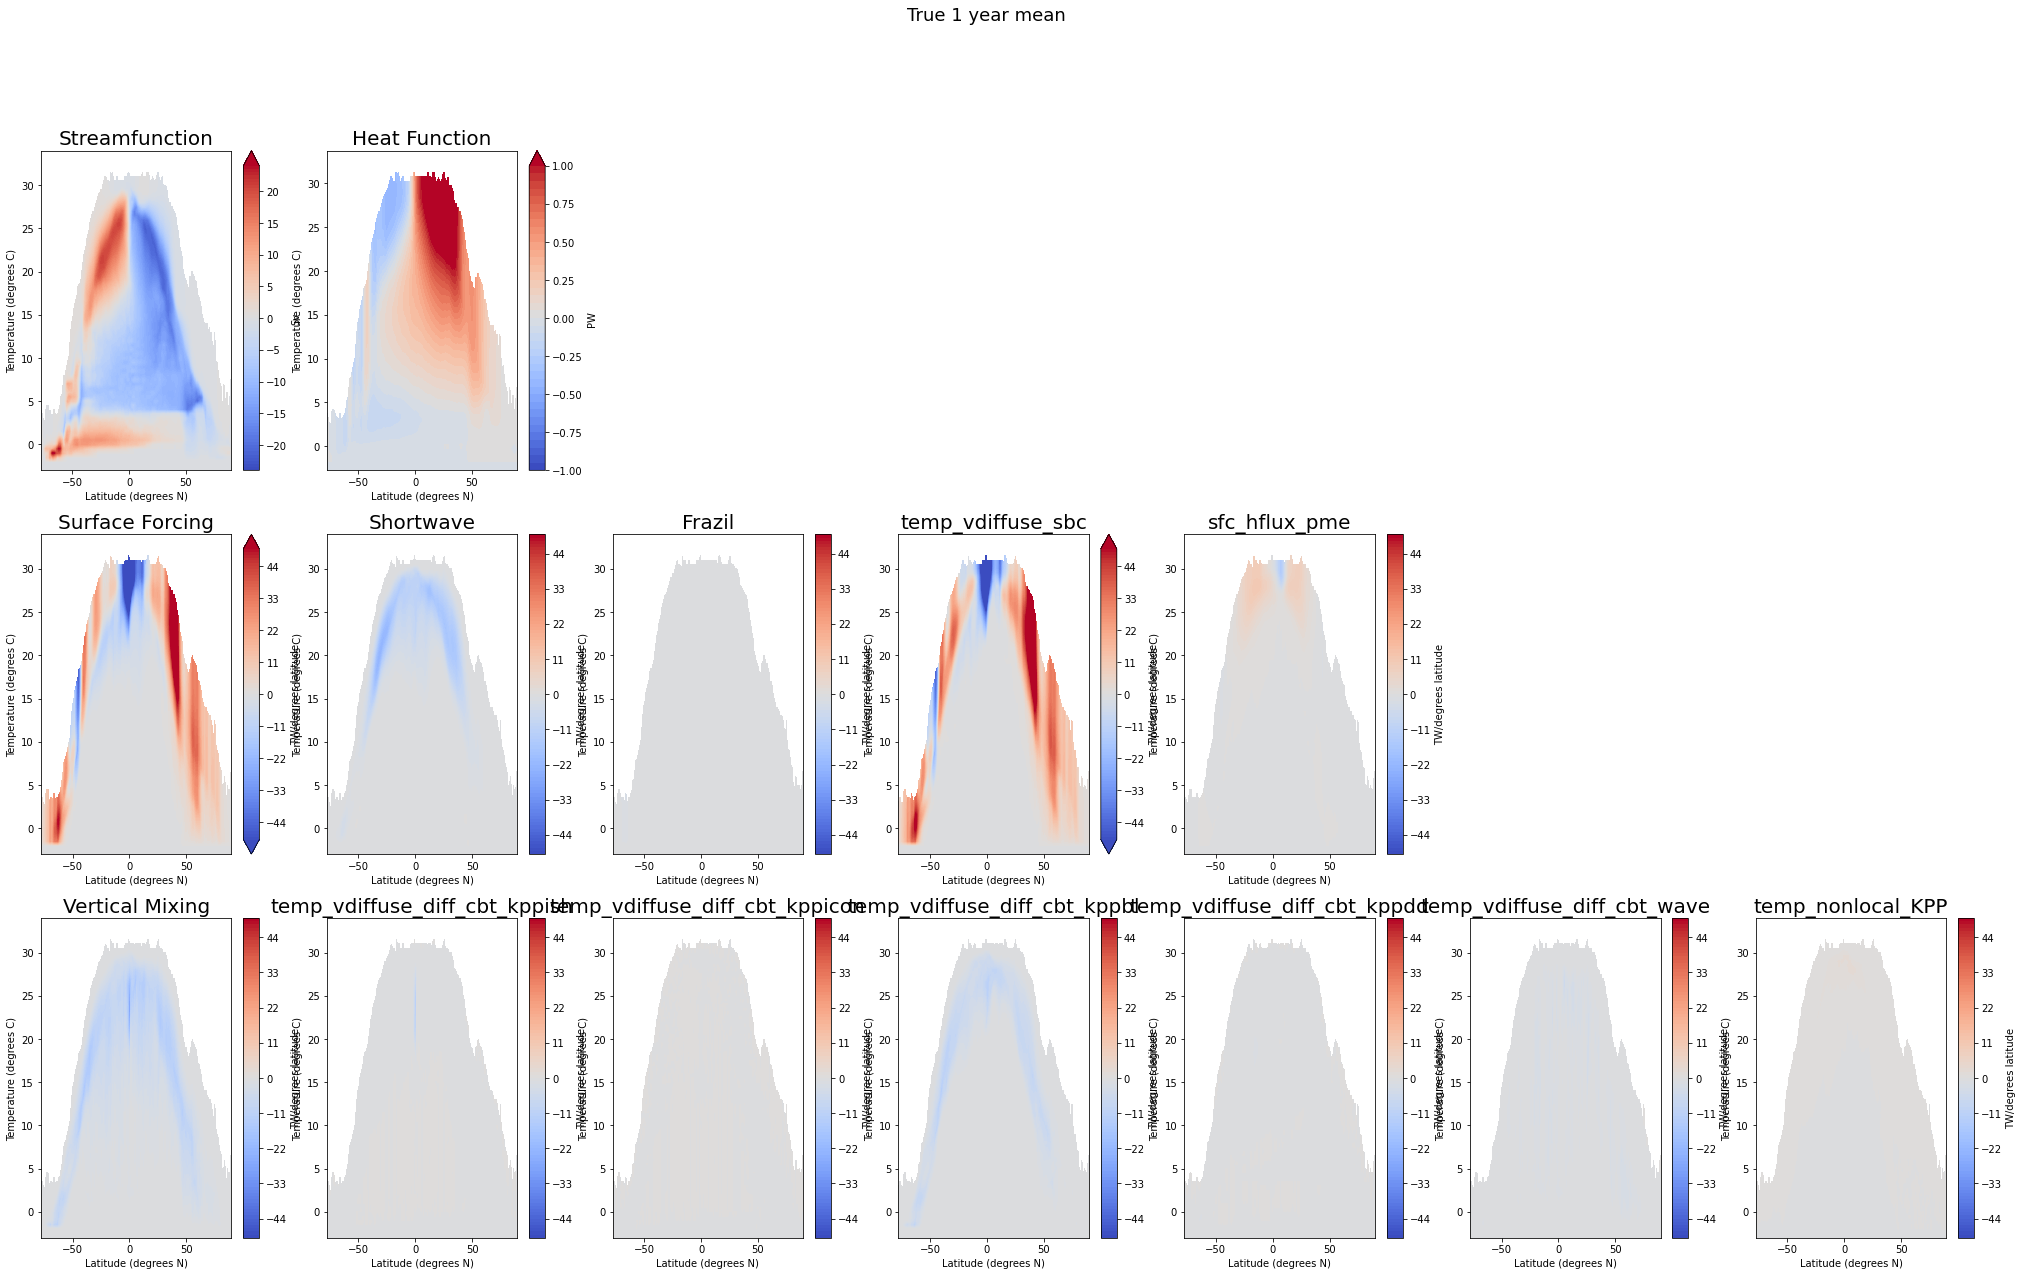

In [22]:
DataSet = True_1year_means
# masking:
maskPsi = 0*True_1year_means.Psi.sum('grid_xt_ocean').where(True_1year_means.Psi.sum('grid_xt_ocean')!=True_1year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)/2
plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'True 1 year mean')

### Load 1 year mean (mean_tot)

In [26]:
%%time

Psi_mean_tot.load()
SF_mean_tot.load()
MX_mean_tot.load()

sw_heat_mean_tot.load()
frazil_3d_mean_tot.load()
temp_vdiffuse_sbc_mean_tot.load()
sfc_hflux_pme_mean_tot.load()
temp_nonlocal_KPP_mean_tot.load()
temp_vdiffuse_diff_cbt_kppish_mean_tot.load()
temp_vdiffuse_diff_cbt_kppicon_mean_tot.load()
temp_vdiffuse_diff_cbt_kppbl_mean_tot.load()
temp_vdiffuse_diff_cbt_kppdd_mean_tot.load()
temp_vdiffuse_diff_cbt_wave_mean_tot.load()

CPU times: user 14.9 s, sys: 1.75 s, total: 16.6 s
Wall time: 25.6 s


<xarray.DataArray 'concatenate-05cc1fac90d02c8a5f218d6263645850' (
                                                                  grid_yt_ocean: 300,
                                                                  grid_xt_ocean: 360,
                                                                  neutralrho_edges: 75)>
array([[[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
...
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]],

       [[-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        ...,
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [54]:
ds = xr.Dataset({'Psi': Psi_mean_tot, 'SF': SF_mean_tot, 'MX': MX_mean_tot, 'sw_heat':sw_heat_mean_tot, 'frazil_3d':frazil_3d_mean_tot, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_tot,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_tot,
                'sfc_hflux_pme':sfc_hflux_pme_mean_tot,'temp_nonlocal_KPP':temp_nonlocal_KPP_mean_tot,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_tot, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_tot,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_tot,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_tot})
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/Mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [24]:
Mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/Mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

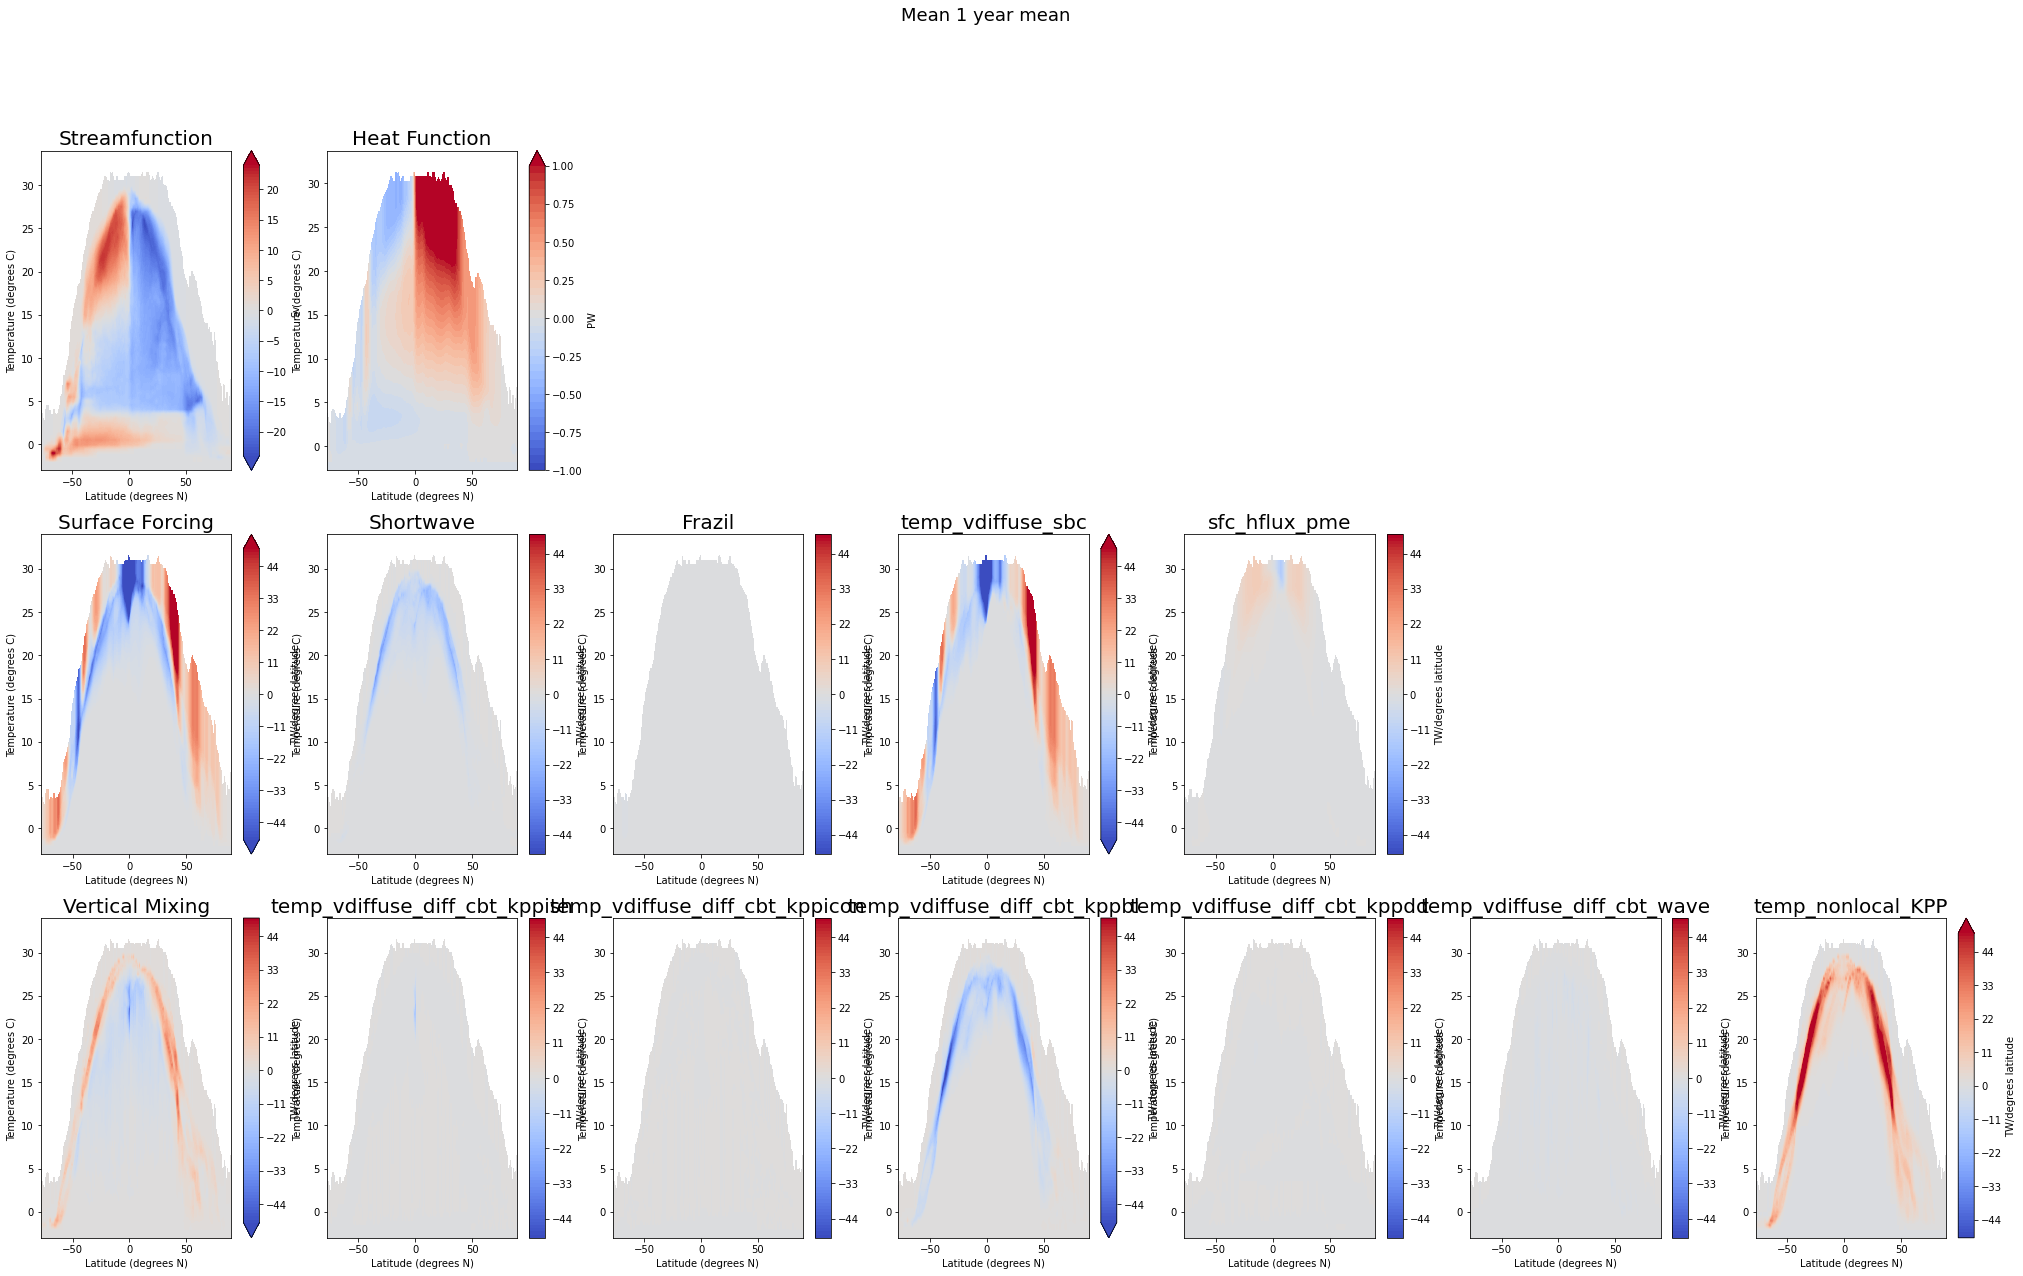

In [41]:
DataSet = Mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)


Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Mean 1 year mean')

### Load 2 month running mean quantities

In [42]:
Psi_mean_2mo = weighted_time_mean_2mo_filter(Psi_mean_2mo)
SF_mean_2mo = weighted_time_mean_2mo_filter(SF_mean_2mo)
MX_mean_2mo = weighted_time_mean_2mo_filter(MX_mean_2mo)

sw_heat_mean_2mo = weighted_time_mean_2mo_filter(sw_heat_mean_2mo)
frazil_3d_mean_2mo = weighted_time_mean_2mo_filter(frazil_3d_mean_2mo)
temp_vdiffuse_sbc_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_sbc_mean_2mo)
sfc_hflux_pme_mean_2mo= weighted_time_mean_2mo_filter(sfc_hflux_pme_mean_2mo)
temp_nonlocal_KPP_mean_2mo= weighted_time_mean_2mo_filter(temp_nonlocal_KPP_mean_2mo)

temp_vdiffuse_diff_cbt_kppish_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppish_mean_2mo)
temp_vdiffuse_diff_cbt_kppicon_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppicon_mean_2mo)
temp_vdiffuse_diff_cbt_kppbl_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppbl_mean_2mo)
temp_vdiffuse_diff_cbt_kppdd_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_kppdd_mean_2mo)
temp_vdiffuse_diff_cbt_wave_mean_2mo = weighted_time_mean_2mo_filter(temp_vdiffuse_diff_cbt_wave_mean_2mo)

In [43]:
%%time

Psi_mean_2mo.load()
SF_mean_2mo.load()
MX_mean_2mo.load()

sw_heat_mean_2mo.load()
frazil_3d_mean_2mo.load()
temp_vdiffuse_sbc_mean_2mo.load()
sfc_hflux_pme_mean_2mo.load()
temp_nonlocal_KPP_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppish_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppicon_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppbl_mean_2mo.load()
temp_vdiffuse_diff_cbt_kppdd_mean_2mo.load()
temp_vdiffuse_diff_cbt_wave_mean_2mo.load()

CPU times: user 3min 4s, sys: 15.9 s, total: 3min 20s
Wall time: 3min 18s


<xarray.DataArray (grid_yt_ocean: 300, grid_xt_ocean: 360, neutralrho_edges: 75)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * grid_yt_ocean     (grid_yt_ocean) float64 -77.88 -77.63 ... 89.32 89.77
  * grid_xt_ocean     (grid_xt_ocean) float64 -279.5 -278.5 -277.5 ... 78.5 79.5
  * neutralrho_edges  (neutralrho_edges) float64 -3.0 -2.5 -2.0 ... 33.5 34.0

In [44]:
ds = xr.Dataset({'Psi': Psi_mean_2mo, 'SF': SF_mean_2mo, 'MX': MX_mean_2mo, 'sw_heat':sw_heat_mean_2mo, 'frazil_3d':frazil_3d_mean_2mo, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_mean_2mo,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_mean_2mo,
                 'sfc_hflux_pme':sfc_hflux_pme_mean_2mo,'temp_nonlocal_KPP':temp_nonlocal_KPP_mean_2mo,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_mean_2mo, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_mean_2mo,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_mean_2mo,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_mean_2mo})
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/2mo_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [45]:
Twomo_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

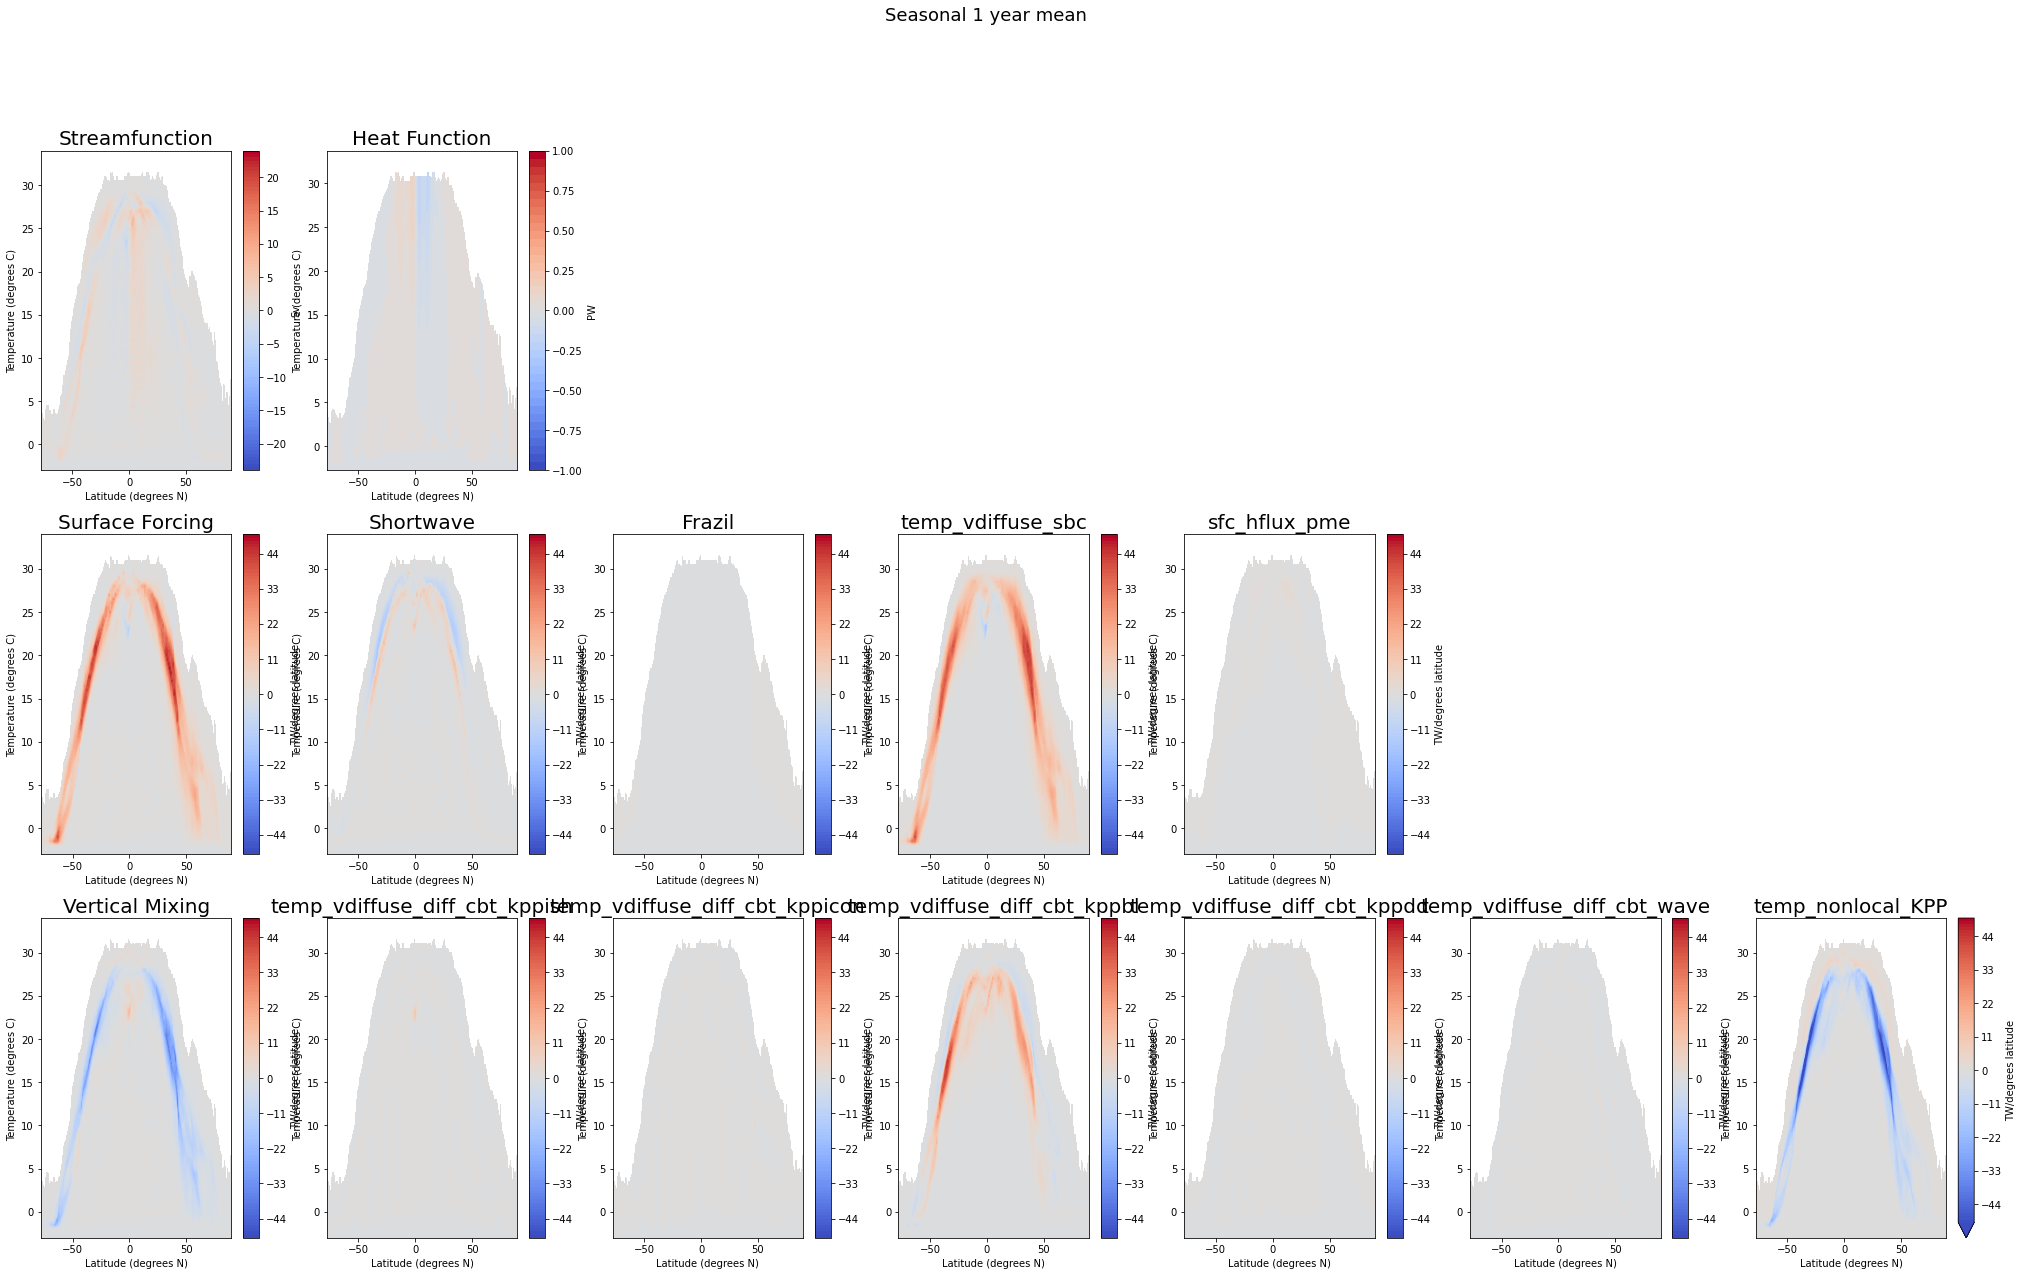

In [46]:
DataSet = Twomo_mean_1year_means - Mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)

cmap = 'coolwarm'

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Seasonal 1 year mean')

### Load 10 daily quantities

have done 0,1,2:

In [ ]:
%%time
for j in np.arange(3,13):
    daily_array = [Psi_mean_10day, SF_10day, MX_10day, sw_heat_10day, frazil_3d_mean_10day, \
                   temp_nonlocal_KPP_mean_10day, sfc_hflux_pme_mean_10day, \
                   temp_vdiffuse_sbc_mean_10day, temp_vdiffuse_diff_cbt_kppish_10day , \
                   temp_vdiffuse_diff_cbt_kppicon_10day, temp_vdiffuse_diff_cbt_kppbl_10day, \
                   temp_vdiffuse_diff_cbt_kppdd_10day, temp_vdiffuse_diff_cbt_wave_10day][j]
    daily_array_name = ['Psi_mean_10day', 'SF_10day', 'MX_10day', 'sw_heat_10day', 'frazil_3d_10day', \
                        'temp_nonlocal_KPP_10day','sfc_hflux_pme_10day', \
                        'temp_vdiffuse_sbc_10day','temp_vdiffuse_diff_cbt_kppish_10day', \
                        'temp_vdiffuse_diff_cbt_kppicon_10day', 'temp_vdiffuse_diff_cbt_kppbl_10day', \
                        'temp_vdiffuse_diff_cbt_kppdd_10day', 'temp_vdiffuse_diff_cbt_wave_10day'][j]
    
    daily_array_timemean = xr.zeros_like(daily_array.isel(time=0))
    nt = len(daily_array.time.values)
    for i in range(12):
        print('Doing time step ' + str(i+1) + ' of ' + str(12))
        if i == 11:
            daily_array_t = daily_array.isel(time=np.arange(i*30,i*30+35)).mean('time');
            fac = 35
        else:
            daily_array_t = daily_array.isel(time=np.arange(i*30,i*30+30)).mean('time');
            fac = 30
        daily_array_t.load()
        daily_array_timemean += daily_array_t*fac
    daily_array_timemean = daily_array_timemean/365
    daily_array_timemean.load()
    ds = xr.Dataset({daily_array_name: daily_array_timemean})
    ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/10daily_mean_1year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12


2022-06-02 14:20:02,616 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Doing time step 10 of 12


2022-06-02 14:21:24,548 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
2022-06-02 14:21:58,115 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Doing time step 11 of 12


2022-06-02 14:23:31,882 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Doing time step 12 of 12


2022-06-02 14:25:10,576 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-06-02 14:26:41,848 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Doing time step 1 of 12


2022-06-02 14:27:33,298 - distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


Doing time step 2 of 12


2022-06-02 14:29:16,237 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Doing time step 3 of 12


2022-06-02 14:30:48,376 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2022-06-02 14:31:32,112 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Doing time step 4 of 12


2022-06-02 14:32:43,303 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Doing time step 5 of 12


2022-06-02 14:34:12,647 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Doing time step 6 of 12


2022-06-02 14:35:32,540 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-06-02 14:36:00,755 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Doing time step 7 of 12


2022-06-02 14:37:30,438 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Doing time step 8 of 12


2022-06-02 14:38:58,316 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Doing time step 9 of 12


2022-06-02 14:40:22,333 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2022-06-02 14:40:53,340 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12
Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12
Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12
Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12
Doing time step 1 of 12
Doing time step 2 of 12
Doin

Needed to do it by month (30days + 35 for last one) because memory intensive.


In [24]:
# load from PBS script output
path = '/scratch/e14/cy8964/temp/1deg_101/'
Psi_mean_10day = xr.open_dataset(path+'10daily_mean_1year_means_Psi_mean_10day.nc').Psi_mean_10day
SF_10day = xr.open_dataset(path+'10daily_mean_1year_means_SF_10day.nc').SF_10day
MX_10day = xr.open_dataset(path+'10daily_mean_1year_means_MX_10day.nc').MX_10day
sw_heat_10day    = xr.open_dataset(path+'10daily_mean_1year_means_sw_heat_10day.nc').sw_heat_10day
frazil_3d_10day    = xr.open_dataset(path+'10daily_mean_1year_means_frazil_3d_10day.nc').frazil_3d_10day
temp_vdiffuse_sbc_10day    = xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_sbc_10day.nc').temp_vdiffuse_sbc_10day
sfc_hfluc_pme_10day    = xr.open_dataset(path+'10daily_mean_1year_means_sfc_hfluc_pme_10day.nc').sfc_hfluc_pme_10day
temp_nonlocal_KPP_10day    = xr.open_dataset(path+'10daily_mean_1year_means_temp_nonlocal_KPP_10day.nc').temp_nonlocal_KPP_10day
temp_vdiffuse_diff_cbt_kppish_10day = xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppish_10day.nc').temp_vdiffuse_diff_cbt_kppish_10day 
temp_vdiffuse_diff_cbt_kppicon_10day= xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppicon_10day.nc').temp_vdiffuse_diff_cbt_kppicon_10day
temp_vdiffuse_diff_cbt_kppbl_10day= xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppbl_10day.nc').temp_vdiffuse_diff_cbt_kppbl_10day
temp_vdiffuse_diff_cbt_kppdd_10day= xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppdd_10day.nc').temp_vdiffuse_diff_cbt_kppdd_10day
temp_vdiffuse_diff_cbt_wave_10day= xr.open_dataset(path+'10daily_mean_1year_means_temp_vdiffuse_diff_cbt_wave_10day.nc').temp_vdiffuse_diff_cbt_wave_10day


In [25]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_10day, 'SF': SF_10day, 'MX': MX_10day, 'sw_heat':sw_heat_10day,'frazil_3d':frazil_3d_10day, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_10day, 'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_10day,
                 'sfc_hflux_pme':sfc_hflux_pme_10day,'temp_nonlocal_KPP':temp_nonlocal_KPP_10day,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_10day, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_10day,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_10day,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_10day})
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/10day_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [26]:
Tenday_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/10day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})

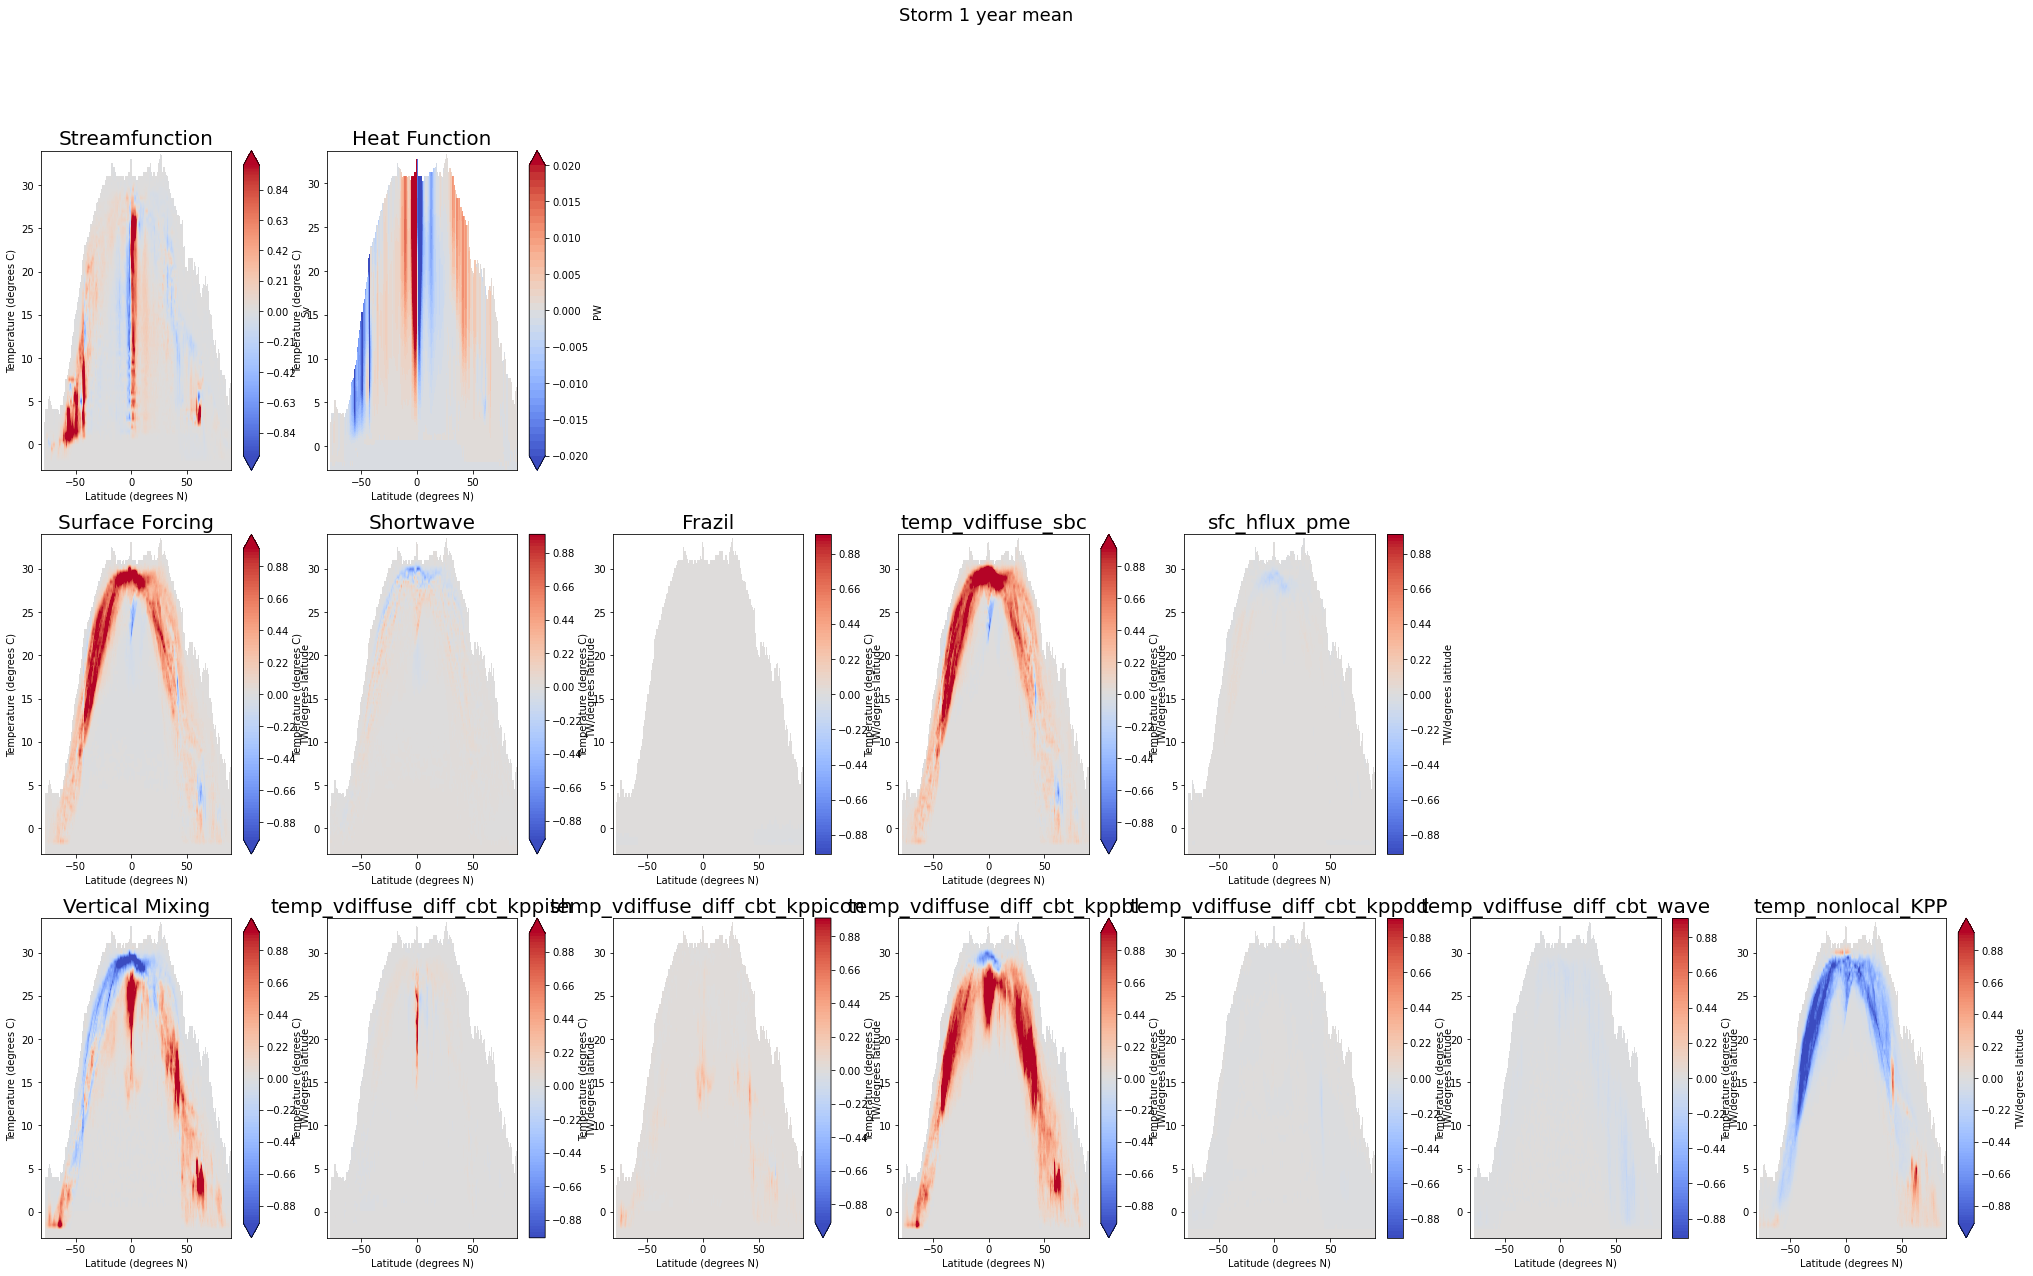

In [28]:
DataSet = Oneday_mean_1year_means - Tenday_mean_1year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Storm 1 year mean')

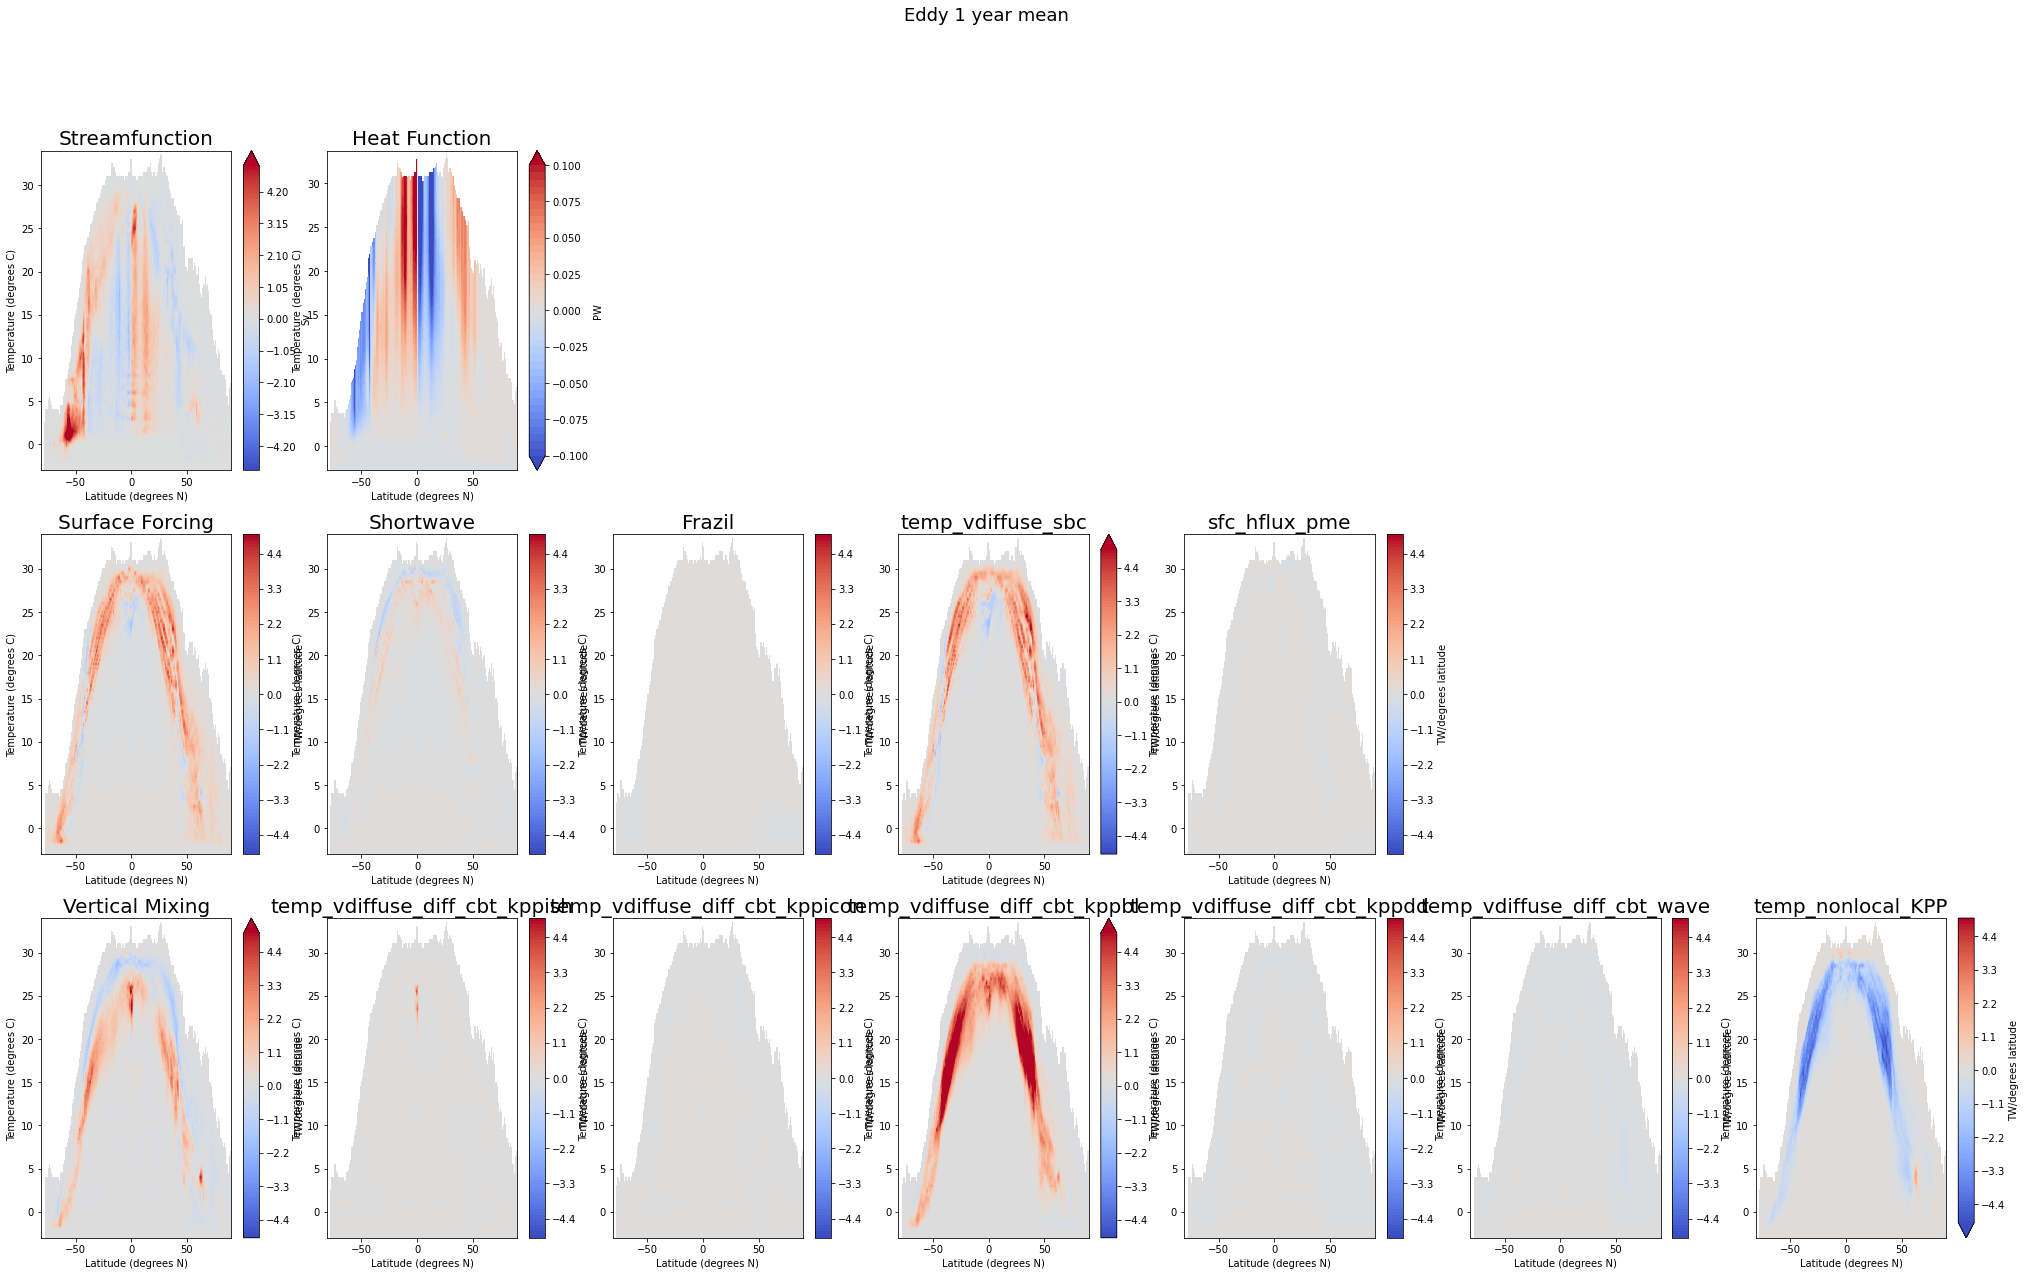

2022-05-05 17:12:06,997 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,121 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,125 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,243 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,248 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,373 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,375 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,378 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,470 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,666 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,669 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,716 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,729 - distributed.nanny - WARNING - Restarting worker
2022-05-05 17:12:07,779 - distributed.

In [29]:

DataSet = Tenday_mean_1year_means - Twomo_mean_1year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Eddy 1 year mean')

### Load 1 daily quantities


In [21]:
%%time
for j in np.arange(2,3):
    daily_array = [Psi_mean_1day, SF_1day, MX_1day, sw_heat_1day, frazil_3d_mean_1day, \
                   temp_nonlocal_KPP_mean_1day, sfc_hflux_pme_mean_1day, \
                   temp_vdiffuse_sbc_mean_1day, temp_vdiffuse_diff_cbt_kppish_1day , \
                   temp_vdiffuse_diff_cbt_kppicon_1day, temp_vdiffuse_diff_cbt_kppbl_1day, \
                   temp_vdiffuse_diff_cbt_kppdd_1day, temp_vdiffuse_diff_cbt_wave_1day][j]
    daily_array_name = ['Psi_mean_1day', 'SF_1day', 'MX_1day', 'sw_heat_1day', 'frazil_3d_1day', \
                        'temp_nonlocal_KPP_1day','sfc_hflux_pme_1day', \
                        'temp_vdiffuse_sbc_1day','temp_vdiffuse_diff_cbt_kppish_1day', \
                        'temp_vdiffuse_diff_cbt_kppicon_1day', 'temp_vdiffuse_diff_cbt_kppbl_1day', \
                        'temp_vdiffuse_diff_cbt_kppdd_1day', 'temp_vdiffuse_diff_cbt_wave_1day'][j]
    
    daily_array_timemean = xr.zeros_like(daily_array.isel(time=0))
    nt = len(daily_array.time.values)
    for i in range(12):
        print('Doing time step ' + str(i+1) + ' of ' + str(12))
        if i == 11:
            daily_array_t = daily_array.isel(time=np.arange(i*30,i*30+35)).mean('time');
            fac = 35
        else:
            daily_array_t = daily_array.isel(time=np.arange(i*30,i*30+30)).mean('time');
            fac = 30
        daily_array_t.load()
        daily_array_timemean += daily_array_t*fac
    daily_array_timemean = daily_array_timemean/365
    daily_array_timemean.load()
    ds = xr.Dataset({daily_array_name: daily_array_timemean})
    ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/1daily_mean_1year_means_'+daily_array_name+'.nc', 
                 encoding={daily_array_name: {'shuffle': True, 'zlib': True, 'complevel': 5}})


Doing time step 1 of 12
Doing time step 2 of 12
Doing time step 3 of 12
Doing time step 4 of 12
Doing time step 5 of 12
Doing time step 6 of 12
Doing time step 7 of 12
Doing time step 8 of 12
Doing time step 9 of 12
Doing time step 10 of 12
Doing time step 11 of 12
Doing time step 12 of 12
CPU times: user 5min 23s, sys: 35.7 s, total: 5min 59s
Wall time: 6min 4s


In [24]:
# load from PBS script output
path = '/scratch/e14/cy8964/temp/1deg_101/'
Psi_mean_1day = xr.open_dataset(path+'1daily_mean_1year_means_Psi_mean_1day.nc').Psi_mean_1day
SF_1day = xr.open_dataset(path+'1daily_mean_1year_means_SF_1day.nc').SF_1day
MX_1day = xr.open_dataset(path+'1daily_mean_1year_means_MX_1day.nc').MX_1day
sw_heat_1day    = xr.open_dataset(path+'1daily_mean_1year_means_sw_heat_1day.nc').sw_heat_1day
frazil_3d_1day    = xr.open_dataset(path+'1daily_mean_1year_means_frazil_3d_1day.nc').frazil_3d_1day
temp_vdiffuse_sbc_1day    = xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_sbc_1day.nc').temp_vdiffuse_sbc_1day
sfc_hfluc_pme_1day    = xr.open_dataset(path+'1daily_mean_1year_means_sfc_hfluc_pme_1day.nc').sfc_hfluc_pme_1day
temp_nonlocal_KPP_1day    = xr.open_dataset(path+'1daily_mean_1year_means_temp_nonlocal_KPP_1day.nc').temp_nonlocal_KPP_1day
temp_vdiffuse_diff_cbt_kppish_1day = xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppish_1day.nc').temp_vdiffuse_diff_cbt_kppish_1day 
temp_vdiffuse_diff_cbt_kppicon_1day= xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppicon_1day.nc').temp_vdiffuse_diff_cbt_kppicon_1day
temp_vdiffuse_diff_cbt_kppbl_1day= xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppbl_1day.nc').temp_vdiffuse_diff_cbt_kppbl_1day
temp_vdiffuse_diff_cbt_kppdd_1day= xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_diff_cbt_kppdd_1day.nc').temp_vdiffuse_diff_cbt_kppdd_1day
temp_vdiffuse_diff_cbt_wave_1day= xr.open_dataset(path+'1daily_mean_1year_means_temp_vdiffuse_diff_cbt_wave_1day.nc').temp_vdiffuse_diff_cbt_wave_1day


In [16]:
# save to array
ds = xr.Dataset({'Psi': Psi_mean_1day, 'SF': SF_1day, 'MX': MX_1day, 'sw_heat':sw_heat_1day, 'frazil_3d':frazil_3d_1day, 'temp_vdiffuse_sbc':temp_vdiffuse_sbc_1day,'temp_vdiffuse_diff_cbt_kppish':temp_vdiffuse_diff_cbt_kppish_1day,
                 'sfc_hflux_pme':sfc_hflux_pme_1day,'temp_nonlocal_KPP':temp_nonlocal_KPP_1day,
                'temp_vdiffuse_diff_cbt_kppicon':temp_vdiffuse_diff_cbt_kppicon_1day, 'temp_vdiffuse_diff_cbt_kppbl':temp_vdiffuse_diff_cbt_kppbl_1day,
                'temp_vdiffuse_diff_cbt_kppdd':temp_vdiffuse_diff_cbt_kppdd_1day,'temp_vdiffuse_diff_cbt_wave':temp_vdiffuse_diff_cbt_wave_1day})
ds.to_netcdf('/scratch/e14/cy8964/temp/1deg_101/1day_mean_1year_means.nc', 
         encoding={'Psi': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'SF': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'MX': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sw_heat': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'frazil_3d': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'sfc_hflux_pme': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_nonlocal_KPP': {'shuffle': True, 'zlib': True, 'complevel': 5},                   
                  'temp_vdiffuse_sbc': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppish': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppicon': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppbl': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_kppdd': {'shuffle': True, 'zlib': True, 'complevel': 5},
                  'temp_vdiffuse_diff_cbt_wave': {'shuffle': True, 'zlib': True, 'complevel': 5}})

In [17]:
Oneday_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/1day_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych})

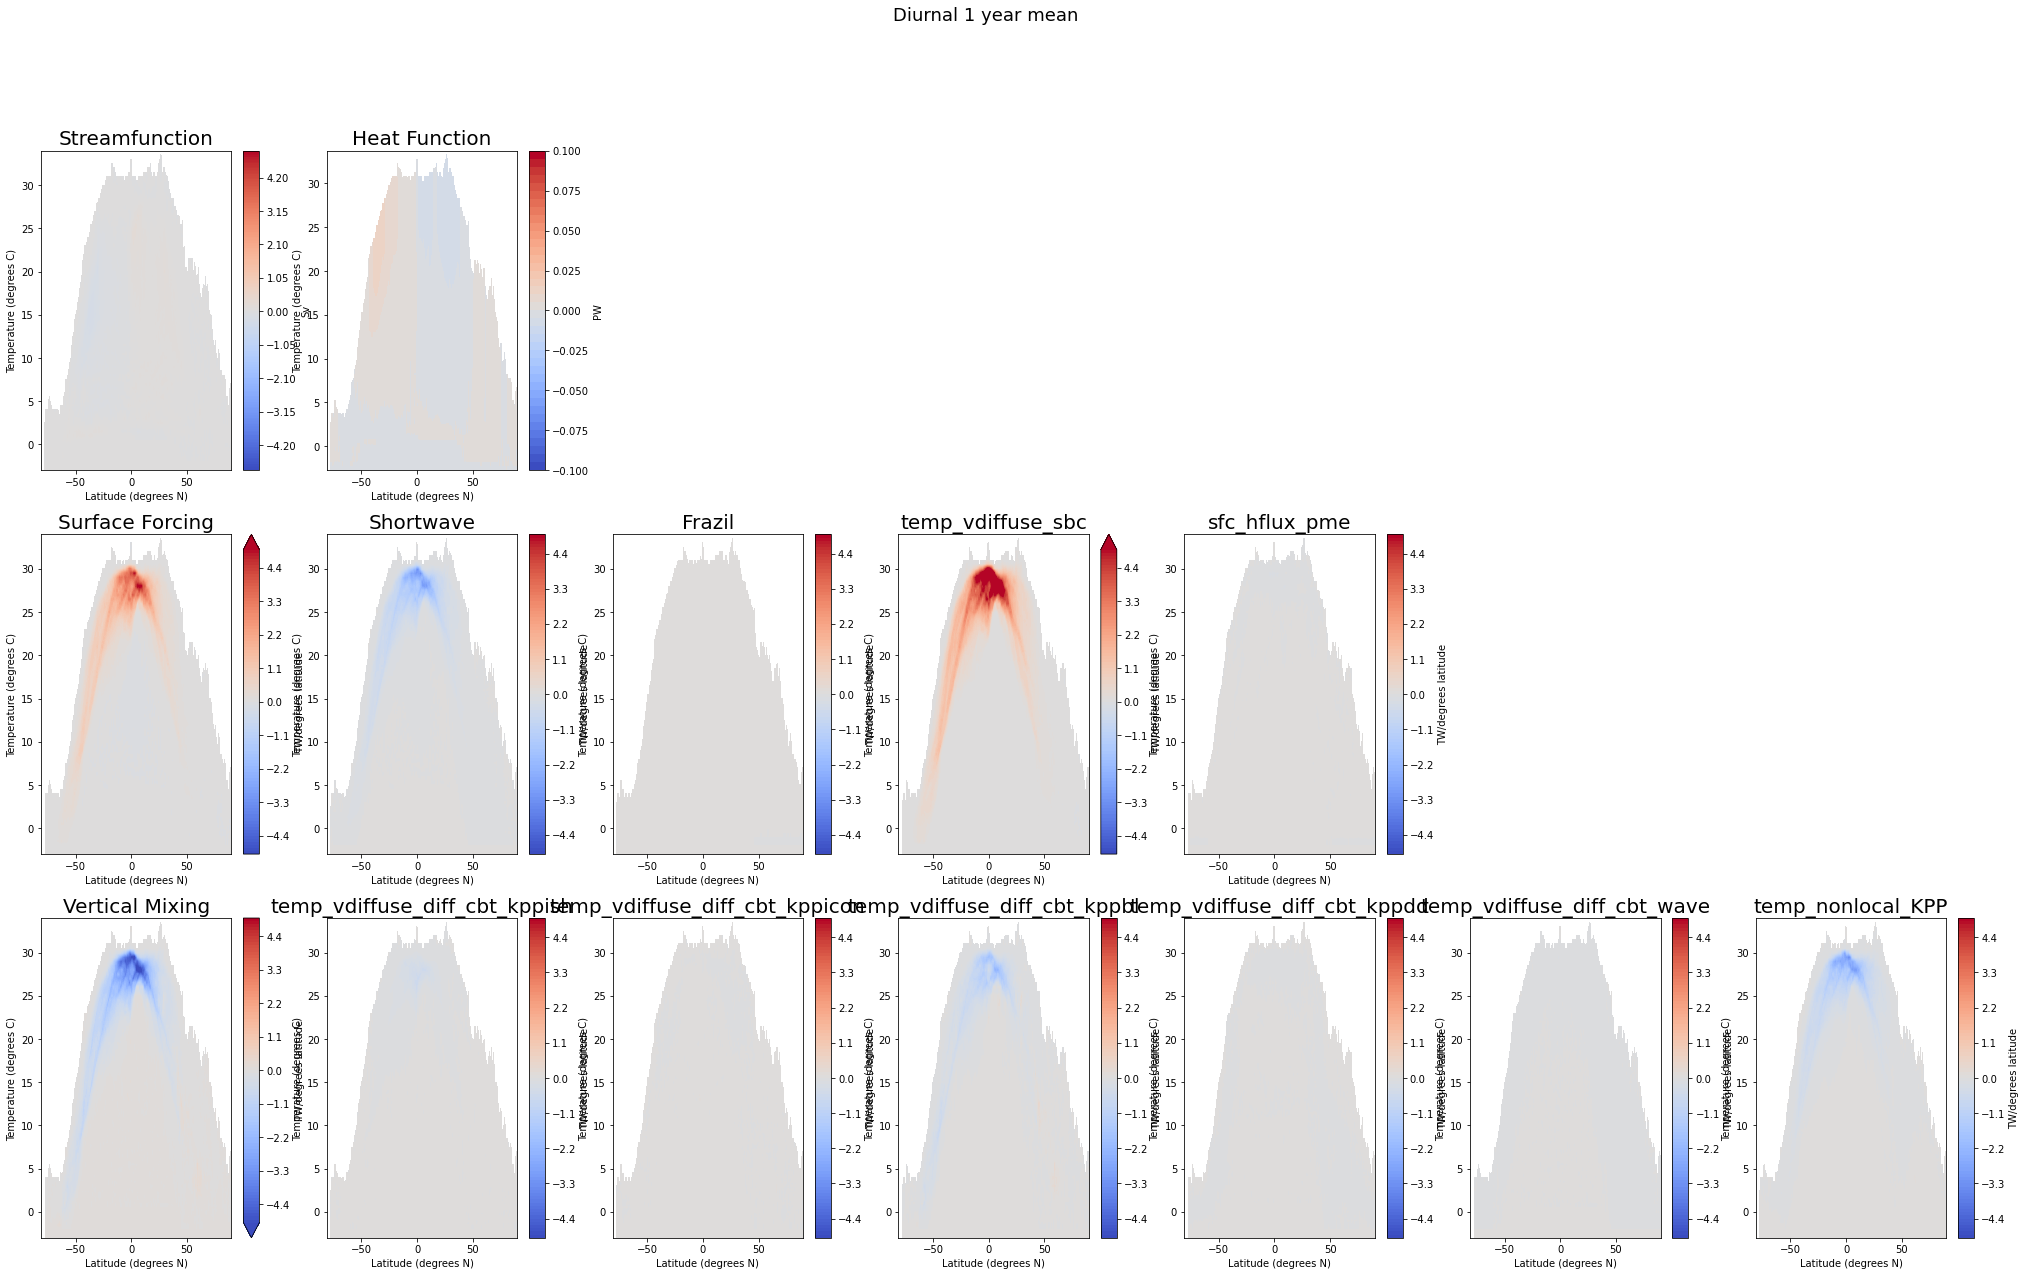

In [22]:
DataSet =  True_1year_means - Oneday_mean_1year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, MXcbar, 'Diurnal 1 year mean')

## Integrate in latitude direction:

In [38]:
def plot_decomp_diathermalHT_3d_to_1d(DataSet, title):

    # Totals in temperature and meridional directions:
    plt.figure(figsize=(14,5))

    plt.subplot()
    (DataSet.SF.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Surface Forcing',color='C0',linewidth=4)
    (DataSet.sw_heat.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Shortwave',color='C1',linewidth=2)
    ((DataSet.SF-DataSet.sw_heat).sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='vdiffuse_sbc+frazil+pme',color='C2',linewidth=2)
    
    (DataSet.MX.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='Vertical Mixing',color='C3',linestyle='dashed',linewidth=4)
    (DataSet.temp_vdiffuse_diff_cbt_kppish.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppish',color='C4',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppicon.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppicon',color='C5',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppbl.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppbl',color='C6',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_kppdd.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_kppdd',color='C7',linestyle='dashed',linewidth=2)
    (DataSet.temp_vdiffuse_diff_cbt_wave.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_vdiffuse_diff_cbt_wave',color='C8',linestyle='dashed',linewidth=2)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    (temp.sum('grid_xt_ocean')/1.e15).sum('grid_yt_ocean').plot(label='temp_nonlocal_KPP',color='C9',linestyle='dashed',linewidth=2)

    plt.legend(bbox_to_anchor = (1,1),loc='upper left', fontsize = 13)
    plt.ylabel('Diathermal Heat Transport (PW)')
    plt.xlabel('Temperature (degrees C)')
    plt.title('Diathermal Heat Transport', fontsize = 18)
    plt.grid()
    plt.xlim([-3.,31.])
    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(right = 0.75)
    plt.show()

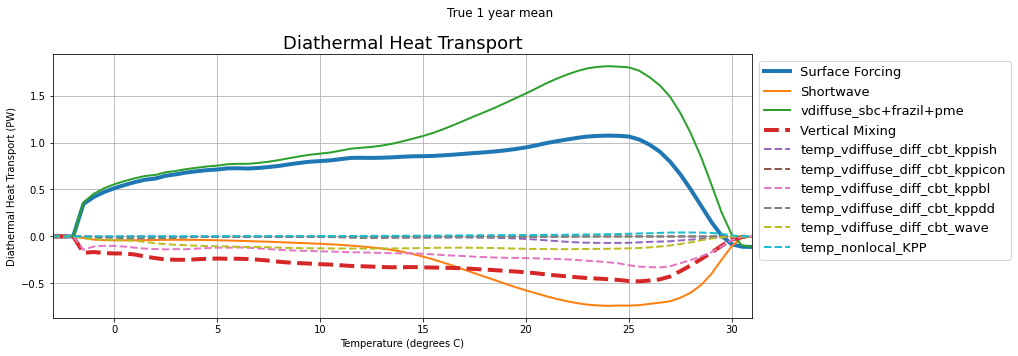

In [39]:
plot_decomp_diathermalHT_3d_to_1d(True_1year_means, 'True 1 year mean')

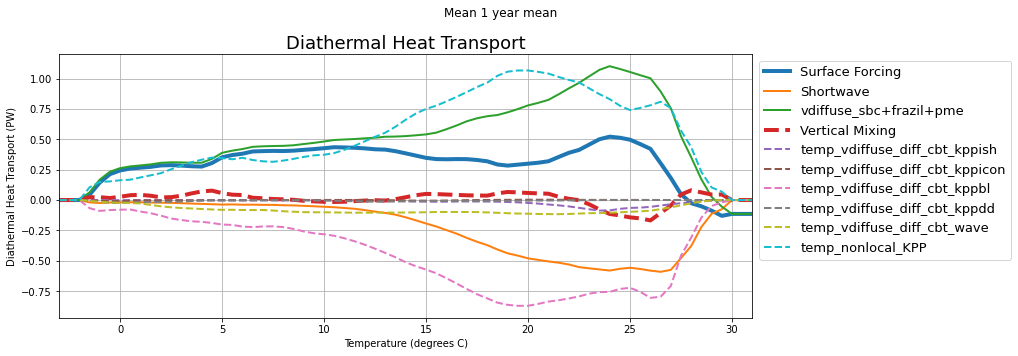

In [40]:
plot_decomp_diathermalHT_3d_to_1d(Mean_1year_means, 'Mean 1 year mean')

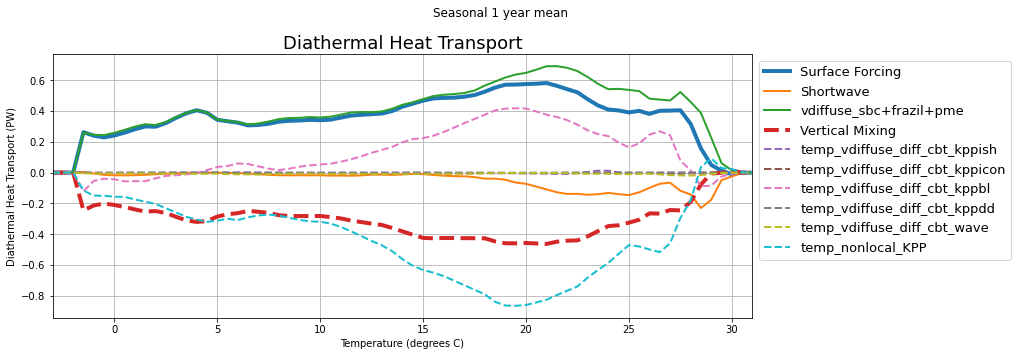

In [41]:
plot_decomp_diathermalHT_3d_to_1d(Twomo_mean_1year_means - Mean_1year_means, 'Seasonal 1 year mean')

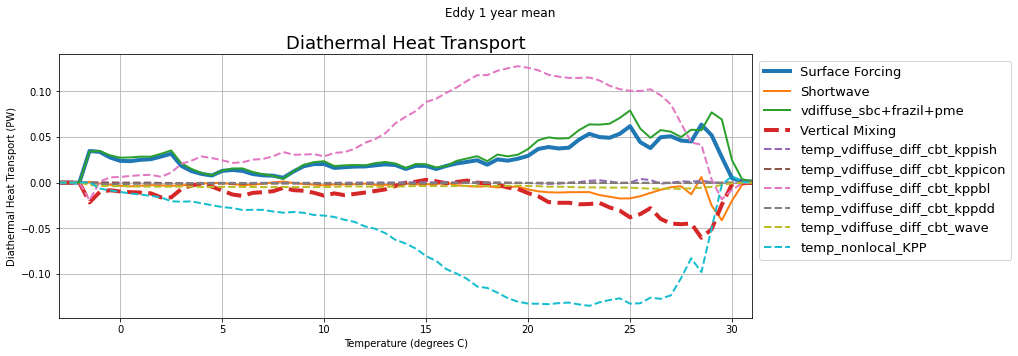

In [44]:
plot_decomp_diathermalHT_3d_to_1d(Tenday_mean_1year_means - Twomo_mean_1year_means, 'Eddy 1 year mean')

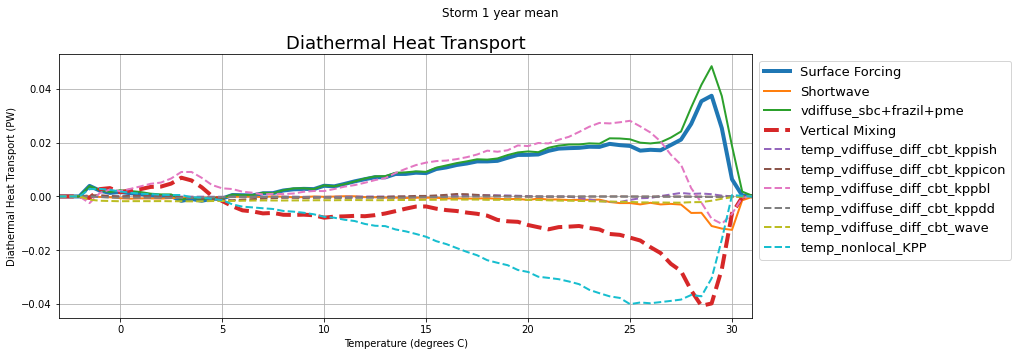

In [103]:
plot_decomp_diathermalHT_3d_to_1d(Oneday_mean_1year_means- Tenday_mean_1year_means , 'Storm 1 year mean')

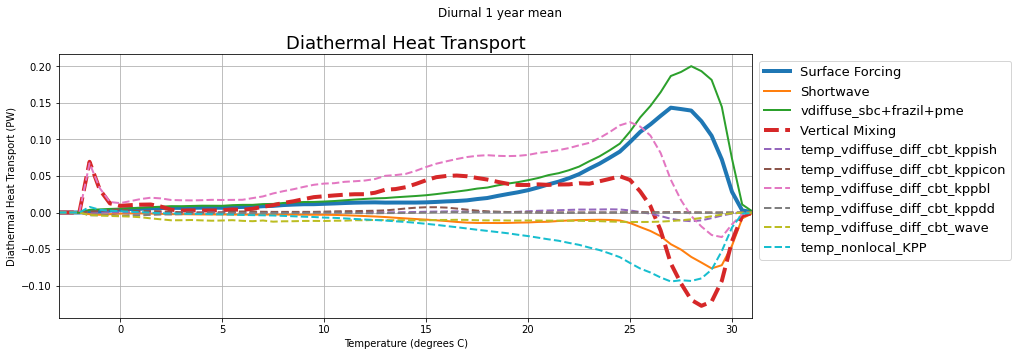

In [104]:
plot_decomp_diathermalHT_3d_to_1d(True_1year_means-Oneday_mean_1year_means , 'Diurnal 1 year mean')

## Spatial Maps Integrated Over Temperature

In [61]:
def plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(50,15),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    plt.subplot(3,7,8)
    (DataSet.SF.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,9)
    (DataSet.temp_vdiffuse_sbc.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,10)
    (DataSet.sw_heat.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,11)
    (DataSet.frazil_3d.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,17)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    ((temp).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')


    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,21)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

In [ ]:
### Draft maps

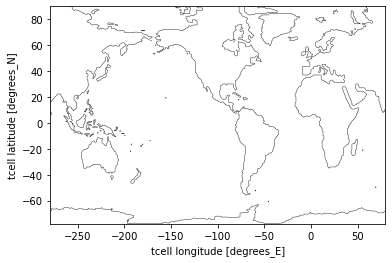

In [4]:
mask = (fgrd.ht.where(fgrd.ht>0)*0+1).fillna(0)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')

In [5]:
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt = gridmn.diff(fgrd.yu_ocean,'y',boundary='extend')
dxt = grid2.diff(fgrd.xu_ocean,'x',boundary='extend')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.01/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encoun

Text(0.5, 0.98, 'ACCESS-OM2 1$^\\circ$ model')

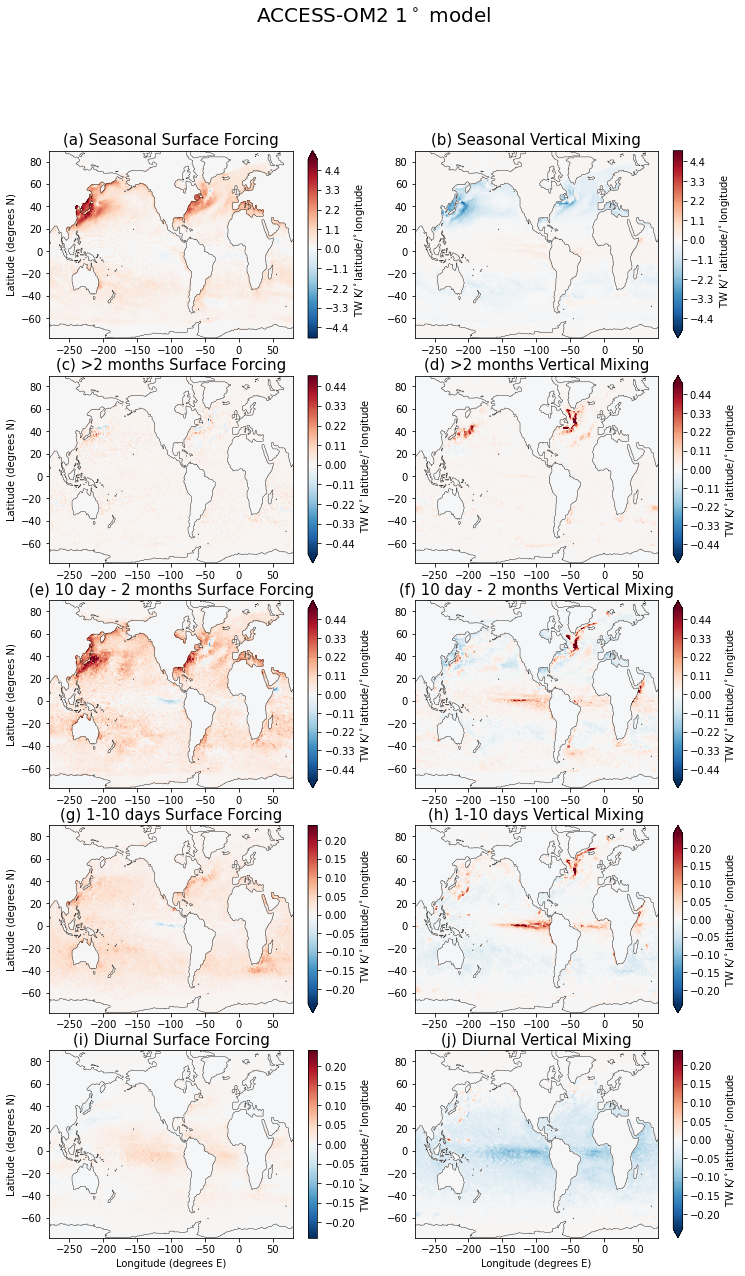

In [6]:
plt.figure(figsize=(12,20),facecolor='w')
cmap = 'RdBu_r'

path = '/scratch/e14/cy8964/temp/1deg_101/'
path2 = '/scratch/e14/cy8964/temp/1deg_102_10yr/'
True_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/True_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Twomo_mean_1year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_101/2mo_mean_1year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
Mean_10year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_102_10yr/Mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
sc_Twomo_10year_means = xr.open_mfdataset('/scratch/e14/cy8964/temp/1deg_102_10yr/sc_2mo_mean_10year_means.nc').chunk({'grid_yu_ocean':ych,'grid_yt_ocean':ych, 'grid_xt_ocean':xch})
SF_10yr = Mean_10year_means.SF
SF_2mo_10yr = xr.open_dataarray(path2+'2mo_mean_10year_means_SF_2mo.nc')
SF_sc_10yr = sc_Twomo_10year_means.SF
SF_2mo = Twomo_mean_1year_means.SF
SF = True_1year_means.SF
SF_10day = xr.open_dataarray(path+'10daily_mean_1year_means_SF_10day.nc')
SF_1day = xr.open_dataarray(path+'1daily_mean_1year_means_SF_1day.nc')
MX_10yr = Mean_10year_means.MX
MX_2mo_10yr = xr.open_dataarray(path2+'2mo_mean_10year_means_MX_2mo.nc')
MX_sc_10yr = sc_Twomo_10year_means.MX
MX_2mo = Twomo_mean_1year_means.MX
MX_1day= xr.open_dataarray(path+'1daily_mean_1year_means_MX_1day.nc')
MX_10day = xr.open_dataarray(path+'10daily_mean_1year_means_MX_10day.nc')
MX = True_1year_means.MX

## Plot data from sc
SFcbar =  np.arange(-5,5.1,0.1)
MXcbar =  np.arange(-5,5.1,0.1)

plt.subplot(5,2,1)
((SF_sc_10yr - SF_10yr).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(a) Seasonal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')

plt.subplot(5,2,2)
((MX_sc_10yr - MX_10yr).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(b) Seasonal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from >2 months Term

SFcbar =  np.arange(-0.5,0.51,0.01)
MXcbar =  np.arange(-0.5,0.51,0.01)

plt.subplot(5,2,3)
((SF_2mo_10yr-SF_sc_10yr).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(c) >2 months Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')


plt.subplot(5,2,4)
((MX_2mo_10yr-MX_sc_10yr).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(d) >2 months Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from 10day-2 months Term

SFcbar =  np.arange(-0.5,0.51,0.01)
MXcbar =  np.arange(-0.5,0.51,0.01)

plt.subplot(5,2,5)
((SF_10day-SF_2mo).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(e) 10 day - 2 months Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')


plt.subplot(5,2,6)
((MX_10day-MX_2mo).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(f) 10 day - 2 months Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from Storm Term

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(5,2,7)
((SF_1day-SF_10day).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(g) 1-10 days Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('')


plt.subplot(5,2,8)
((MX_1day-MX_10day).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(h) 1-10 days Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('')

## Plot data from Diurnal

SFcbar = np.arange(-0.24,0.245,0.005)
MXcbar = np.arange(-0.24,0.245,0.005)

plt.subplot(5,2,9)
((SF-SF_1day).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(i) Diurnal Surface Forcing', fontsize = 15)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')


plt.subplot(5,2,10)
((MX-MX_1day).sum('neutralrho_edges')/1.e12/dx/dy*dT).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW K/$^\circ$latitude/$^\circ$longitude'},cmap=cmap)
mask.plot.contour(levels = [0.5],linewidths = 0.4, colors = 'k')
plt.title('(j) Diurnal Vertical Mixing', fontsize = 15)
plt.ylabel('')
plt.xlabel('Longitude (degrees E)')


plt.suptitle('ACCESS-OM2 1$^\circ$ model', fontsize = 20)

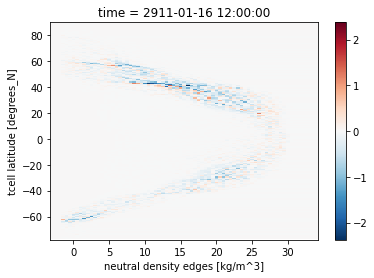

In [7]:
((SF_2mo_10yr-SF_sc_10yr).sum('grid_xt_ocean')/1.e12/dy).plot()